#### BGMM Regime Detection

C:\Users\guoqi\AppData\Local\Temp\ipykernel_17308\3176225116.py:82: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return df.sort_index().resample("M").last()


Original active IDs: [0, 1, 2, 3, 5]
Compacted IDs mapping: {0: 0, 1: 1, 2: 2, 3: 3, 5: 4}
Train regime IDs (compact): [0, 1, 2, 3]
Test  regime IDs (compact): [0, 1, 2, 3, 4]
Test-only novel IDs (compact): [4]
TEST regimes before merge: [0, 3, 1, 4, 2]
TEST regimes after merge : [0, 1, 3]
Final Train regime IDs: [0, 1, 2, 3]
Final Test  regime IDs: [0, 1, 3]
Final Test-only novel IDs: []


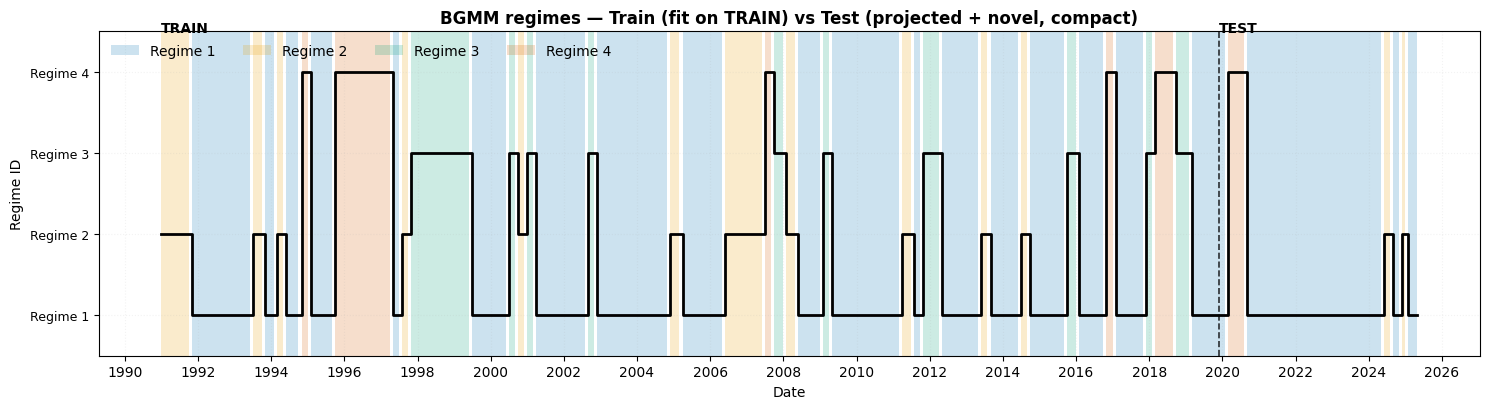

Active FULL-SAMPLE regimes: 5


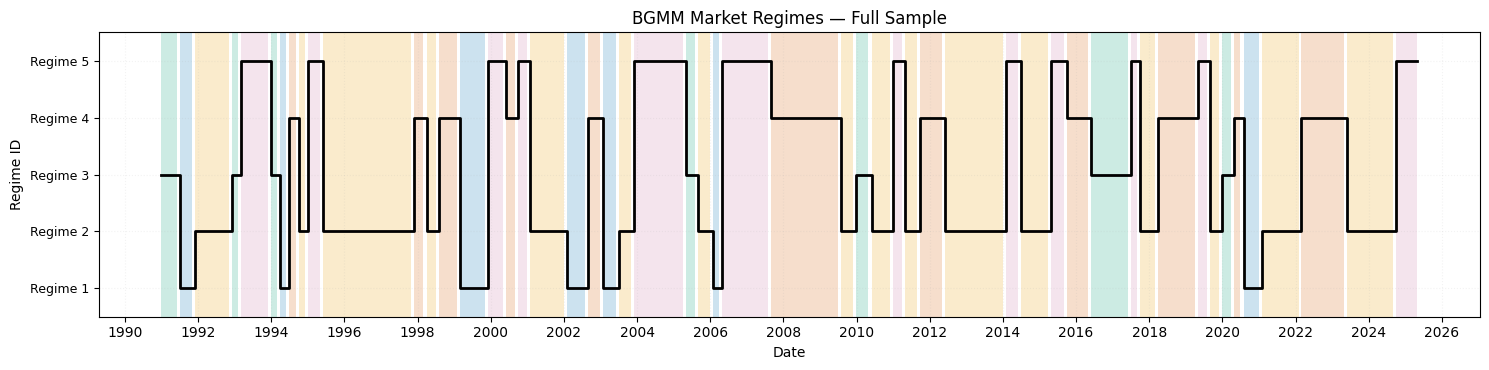


OOS diagnostics — LL gap: 12.32 | AMI: 0.068 | ARI: 0.020


In [26]:
# ============================================================
# BGMM Regime Detection — Combined Script (with TEST compaction)
# - Leak-safe robust scaling
# - Train-only whitening for Train→Test; full-sample whitening for Full run
# - BGMM with persistence on TRAIN regimes
# - TEST:
#     * can have a novel regime (or regimes) not present in TRAIN
#     * rare / unstable regimes are pruned / merged into a small number
# - Plots: (1) Train vs Test, (2) Full Sample
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from pandas.tseries.offsets import MonthEnd
from scipy.stats import median_abs_deviation
from sklearn.mixture import BayesianGaussianMixture
from sklearn.covariance import LedoitWolf
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import pairwise_distances  # for merging test regimes

# ------------------------------------------------------------
# Paths / data
# ------------------------------------------------------------
FEATURES_XLSX = r"C:\Users\guoqi\Desktop\top_features_df.csv"
RETURNS_CSV   = r"C:\Users\guoqi\Desktop\Initial Data Package for Cornell Capstone Project\df_1M_ret.csv"

RETURN_COL = "Russell 1000"

START_DATE = pd.Timestamp("1990-01-31")
END_DATE   = None
TRAIN_END  = pd.Timestamp("2019-12-01")

# Robust scaling
ROLL_WIN  = 24
Z_CLIP    = 4.0

# BGMM (penalized)
N_COMPONENTS_MAX = 5
COVARIANCE_TYPE  = "tied"          # try "diag" for extra stability after whitening
WCP_TYPE         = "dirichlet_process"
WCP              = 2.0
MEAN_PRECISION   = 0.05
REG_COV          = 5e-4
MAX_ITER         = 2000
RANDOM_STATE     = 42
TINY_WEIGHT      = 1e-4

# Persistence (for train regimes)
ENABLE_SMOOTHING_HYSTERESIS = True
SMOOTH_WINDOW = 3
HIGH_THR      = 0.60
LOW_THR       = 0.40
ENABLE_MIN_DWELL = True
MIN_DWELL        = 3

# Novel regime hyper-parameters
NOVEL_THRESHOLD   = 0.60   # if max p(train_regime | x) < this → treat as novel
N_COMPONENTS_NEW  = 1      # max # of new regimes on novel test data (before merging)

# TEST simplification hyper-parameters
MIN_TEST_MONTHS_PER_REGIME = 3   # prune very rare regimes in test
K_TEST_MAX = 3                   # final max number of regimes in test after merging


# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def load_monthly(path: str) -> pd.DataFrame:
    if path.lower().endswith((".xls", ".xlsx")):
        df = pd.read_excel(path)
    else:
        df = pd.read_csv(path)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
    else:
        df.index = pd.to_datetime(df.index)
    # month-end align
    return df.sort_index().resample("M").last()


def robust_roll_scale(dfin: pd.DataFrame, win: int = 24, clip: float = 4.0) -> pd.DataFrame:
    med = dfin.rolling(win, min_periods=max(6, win//3)).median()
    mad = dfin.rolling(win, min_periods=max(6, win//3)).apply(
        lambda x: median_abs_deviation(x, scale='normal'), raw=False
    )
    med_lag = med.shift(1)
    mad_lag = mad.shift(1).where(lambda s: s > 1e-8, 1e-8)
    z = (dfin - med_lag) / mad_lag
    return z.clip(-clip, clip).dropna()


def make_whitener(Z_center_for_cov: pd.DataFrame):
    """Return Winv_sqrt based on Ledoit–Wolf fit on provided centered matrix."""
    lw = LedoitWolf().fit(Z_center_for_cov.values)
    Sigma_hat = lw.covariance_
    lam, V = np.linalg.eigh(Sigma_hat)
    Winv_sqrt = V @ np.diag(1.0 / np.sqrt(np.clip(lam, 1e-8, None))) @ V.T
    return Winv_sqrt


def combine_and_scale_features_only(FEATURES_XLSX, start, end):
    """
    Load macro/features ONLY (no returns), align to month-end, 
    filter missingness, and robust-roll-scale.
    Returns:
        df_feat : original (filtered) features at monthly frequency
        Z       : robust-rolled z-scores (leak-safe) used by BGMM
    """
    # Load features, forward-fill a bit for mild gaps
    df_feat = load_monthly(FEATURES_XLSX).ffill(limit=12).loc[start:end]

    # Keep columns with enough history
    col_keep = df_feat.columns[df_feat.notna().mean() >= 0.50]
    panel = df_feat[col_keep].copy()

    # Keep months with enough cross-section completeness
    row_keep = panel.index[panel.notna().mean(axis=1) >= 0.80]
    panel = panel.loc[row_keep].copy().ffill(limit=3).dropna(how="any")

    # Leak-safe robust scaling (median/MAD with a 1-month lag)
    Z = robust_roll_scale(panel, win=ROLL_WIN, clip=Z_CLIP)
    return panel, Z


def hysteresis_labels(resp_df: pd.DataFrame, high_thr=0.6, low_thr=0.4, win=3) -> pd.Series:
    rs = resp_df.rolling(win, min_periods=1).mean()
    labels, prev_k = [], None
    for t in rs.index:
        p = rs.loc[t].values
        k_now = int(np.argmax(p))
        if prev_k is None:
            prev_k = k_now
        else:
            if k_now != prev_k:
                if (p[prev_k] < low_thr) and (p[k_now] > high_thr):
                    prev_k = k_now
        labels.append(prev_k)
    return pd.Series(labels, index=rs.index, name="regime_id")


def enforce_min_dwell(labels: pd.Series, resp_df: pd.DataFrame, min_len: int = 3) -> pd.Series:
    lab = labels.copy().astype(int)
    idx = lab.index
    start = 0
    while start < len(lab):
        end = start
        while end + 1 < len(lab) and lab.iloc[end + 1] == lab.iloc[start]:
            end += 1
        run_len = end - start + 1
        if run_len < min_len:
            left_k  = lab.iloc[start - 1] if start - 1 >= 0 else None
            right_k = lab.iloc[end + 1]   if end + 1 < len(lab) else None
            if (left_k is None) and (right_k is None):
                pass
            elif (left_k is None) or (right_k is None):
                repl = left_k if right_k is None else right_k
                lab.iloc[start:end + 1] = repl
            else:
                win = idx[start:end + 1]
                p_left  = float(resp_df.loc[win, f"k{left_k}"].mean())
                p_right = float(resp_df.loc[win, f"k{right_k}"].mean())
                lab.iloc[start:end + 1] = left_k if p_left >= p_right else right_k
        start = end + 1
    return lab


def make_bgmm():
    return BayesianGaussianMixture(
        n_components=N_COMPONENTS_MAX,
        covariance_type=COVARIANCE_TYPE,
        weight_concentration_prior_type=WCP_TYPE,
        weight_concentration_prior=WCP,
        mean_precision_prior=MEAN_PRECISION,
        reg_covar=REG_COV,
        init_params="kmeans",
        max_iter=MAX_ITER,
        random_state=RANDOM_STATE
    )


def assign_with_persistence(resp_df: pd.DataFrame, weights: np.ndarray) -> pd.Series:
    tiny_idx = set(np.where(weights < TINY_WEIGHT)[0].tolist())
    lab = hysteresis_labels(resp_df, high_thr=HIGH_THR, low_thr=LOW_THR, win=SMOOTH_WINDOW)
    lab = lab.where(~lab.isin(tiny_idx), -1)
    if ENABLE_MIN_DWELL:
        lab = enforce_min_dwell(lab, resp_df, min_len=MIN_DWELL)
    return lab.rename("regime_id")


def relabel_by_weight(resp_list, weights):
    """
    Canonicalize BGMM component labels by descending mixture weight.

    resp_list: list of DataFrames, each with columns ['k0', 'k1', ...].
    weights : array-like, length K.
    Returns:
        new_resps: list of DataFrames with columns ['k0','k1',...]
                   reordered so k0 has largest weight, etc.
        new_weights: weights in the new order.
        perm: permutation mapping new_index -> old_index.
    """
    K = len(weights)
    perm = np.argsort(-weights)  # largest → 0
    new_weights = weights[perm]
    new_cols = [f"k{j}" for j in range(K)]

    new_resps = []
    for resp in resp_list:
        old_cols = [f"k{j}" for j in range(K)]
        resp_reordered = resp[[old_cols[j] for j in perm]].copy()
        resp_reordered.columns = new_cols
        new_resps.append(resp_reordered)

    return new_resps, new_weights, perm


def extend_with_novel_regimes(
    resp_tr, resp_te, w_tr,
    X_test,
    novel_threshold=NOVEL_THRESHOLD,
    n_components_new=N_COMPONENTS_NEW
):
    """
    Build extended responsibilities (train+test) with TEST-only novel regimes.

    Steps:
      1) Identify test rows with max_k p_train(k|x) < novel_threshold.
      2) Fit BGMM on those "novel" X_test rows.
      3) Return:
           - resp_tr_full: train responsibilities with K_old + K_new columns
           - resp_te_full: test responsibilities with K_old + K_new columns
               * non-novel rows: probs only in 0..K_old-1
               * novel rows: probs only in K_old..K_full-1
           - w_full: combined weights
           - novel_mask: boolean Series over X_test.index (True for novel rows)
    """
    K_old = resp_tr.shape[1]

    # 1) novel detection on test
    max_prob = resp_te.max(axis=1)
    novel_mask = max_prob < novel_threshold

    # If no novel points, just return original
    if not novel_mask.any():
        resp_tr_full = resp_tr.copy()
        resp_te_full = resp_te.copy()
        w_full = w_tr.copy()
        return resp_tr_full, resp_te_full, w_full, novel_mask

    # 2) fit BGMM on novel test only
    X_novel = X_test.loc[novel_mask]
    n_novel = len(X_novel)
    n_comp = min(n_components_new, n_novel)

    if n_comp <= 0:
        resp_tr_full = resp_tr.copy()
        resp_te_full = resp_te.copy()
        w_full = w_tr.copy()
        return resp_tr_full, resp_te_full, w_full, novel_mask

    bg_new = BayesianGaussianMixture(
        n_components=n_comp,
        covariance_type=COVARIANCE_TYPE,
        weight_concentration_prior_type=WCP_TYPE,
        weight_concentration_prior=WCP,
        mean_precision_prior=MEAN_PRECISION,
        reg_covar=REG_COV,
        init_params="kmeans",
        max_iter=MAX_ITER,
        random_state=RANDOM_STATE
    ).fit(X_novel.values)

    resp_novel_raw = pd.DataFrame(
        bg_new.predict_proba(X_novel.values),
        index=X_novel.index,
        columns=[f"k_new{j}" for j in range(bg_new.n_components)]
    )

    # sort new components by descending weight
    perm_new = np.argsort(-bg_new.weights_)
    resp_novel = resp_novel_raw[[f"k_new{j}" for j in perm_new]].copy()
    w_new = bg_new.weights_[perm_new]

    K_new = len(w_new)
    total_cols = [f"k{j}" for j in range(K_old + K_new)]

    # 3) build full train/test responsibilities
    resp_tr_full = pd.DataFrame(0.0, index=resp_tr.index, columns=total_cols)
    resp_tr_full[[f"k{j}" for j in range(K_old)]] = resp_tr.values  # no novel in train

    resp_te_full = pd.DataFrame(0.0, index=resp_te.index, columns=total_cols)
    # non-novel: keep old components
    resp_te_full.loc[~novel_mask, [f"k{j}" for j in range(K_old)]] = resp_te.loc[~novel_mask].values
    # novel: put probs into new components only
    resp_te_full.loc[novel_mask, [f"k{K_old + j}" for j in range(K_new)]] = resp_novel.values

    w_full_raw = np.concatenate([w_tr, w_new])
    w_full = w_full_raw / w_full_raw.sum()

    return resp_tr_full, resp_te_full, w_full, novel_mask


# ------------------------------------------------------------
# Plotting
# ------------------------------------------------------------
def _runs(index, values):
    start = None; prev = None; last_t = None
    for t, v in zip(index, values):
        if pd.isna(v):
            if start is not None:
                yield start, last_t, prev
                start = None; prev = None
        else:
            if (start is None) or (v != prev):
                if start is not None:
                    yield start, last_t, prev
                start = t; prev = v
        last_t = t
    if start is not None:
        yield start, last_t, prev


def _palette(K):
    base = ["#0072B2","#E69F00","#009E73","#D55E00","#CC79A7",
            "#56B4E9","#F0E442","#000000","#999999"]
    return (base * (K // len(base) + 1))[:K]


def _format_dates(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(alpha=0.15, linestyle=":", linewidth=0.8)


def plot_train_test_merged(reg_tr: pd.Series,
                           reg_te: pd.Series,
                           split_date: pd.Timestamp,
                           title: str = "BGMM regimes — Train (left) vs Test (right)"):
    s_tr = reg_tr.copy().astype("int64")
    s_te = reg_te.copy().astype("int64")

    merged = pd.concat([s_tr.loc[:split_date], s_te.loc[split_date + MonthEnd(1):]])
    merged.name = "regime_id"

    K = int(merged[merged >= 0].max() if (merged >= 0).any() else -1) + 1
    pal = _palette(K)

    fig, ax = plt.subplots(figsize=(15, 4.2))

    y_plot = merged.astype(float).where(lambda x: x >= 0) + 1
    for st, en, val in _runs(y_plot.index, y_plot.values):
        if np.isnan(val):
            continue
        rid = int(val - 1)
        ax.axvspan(st, en, color=pal[rid], alpha=0.20, lw=0)

    ax.plot(y_plot.index, y_plot.values, color="k", lw=2.0, drawstyle="steps-post")

    if K > 0:
        ax.set_yticks(np.arange(1, K + 1))
        ax.set_yticklabels([f"Regime {i+1}" for i in range(K)], fontsize=9)
        ax.set_ylim(0.5, K + 0.5)

    ax.axvline(split_date, color="k", ls="--", lw=1.2, alpha=0.8)
    xmin, xmax = y_plot.index.min(), y_plot.index.max()
    ax.text(xmin, K + 0.45, "TRAIN", va="bottom", ha="left", fontsize=10, weight="bold")
    ax.text(split_date, K + 0.45, "TEST", va="bottom", ha="left", fontsize=10, weight="bold")

    handles = [Patch(facecolor=pal[i], alpha=0.20, edgecolor="none", label=f"Regime {i+1}")
               for i in range(K)]
    ax.legend(handles=handles, loc="upper left", ncol=min(K, 5), frameon=False)

    _format_dates(ax)
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Date"); ax.set_ylabel("Regime ID")
    plt.tight_layout(); plt.show()


def plot_full(reg: pd.Series, title="BGMM Market Regimes — Full Sample"):
    K = int(reg[reg>=0].max() if (reg>=0).any() else -1) + 1
    pal = _palette(K)
    fig, ax = plt.subplots(figsize=(15, 3.8))
    y = reg.astype(float).where(lambda x: x>=0) + 1
    for st, en, val in _runs(y.index, y.values):
        if np.isnan(val): continue
        rid = int(val-1)
        ax.axvspan(st, en, color=pal[rid], alpha=0.20, lw=0)
    ax.plot(y.index, y.values, color="k", lw=2.0, drawstyle="steps-post")
    if K > 0:
        ax.set_yticks(np.arange(1, K+1))
        ax.set_yticklabels([f"Regime {i+1}" for i in range(K)], fontsize=9)
        ax.set_ylim(0.5, K+0.5)
    ax.set_title(title)
    _format_dates(ax)
    ax.set_xlabel("Date"); ax.set_ylabel("Regime ID")
    plt.tight_layout(); plt.show()


# ============================================================
# MAIN FLOW
# ============================================================
# data scaling
df_m, Z = combine_and_scale_features_only(FEATURES_XLSX, START_DATE, END_DATE)

# TRAIN→TEST (train-only whitening) 
Z_tr = Z.loc[:TRAIN_END]
Z_te = Z.loc[TRAIN_END + MonthEnd(1):]  # strict split

# center & whiten using TRAIN only
mu_tr = Z_tr.mean()
Zc_tr = Z_tr - mu_tr
Zc    = Z - mu_tr
Winv_train = make_whitener(Zc_tr)
X      = pd.DataFrame(Zc.values @ Winv_train, index=Z.index, columns=Z.columns)
X_train = X.loc[:TRAIN_END]
X_test  = X.loc[TRAIN_END + MonthEnd(1):]

# 1) Fit BGMM on TRAIN
bg_tr = make_bgmm().fit(X_train.values)

resp_tr_raw = pd.DataFrame(
    bg_tr.predict_proba(X_train.values),
    index=X_train.index,
    columns=[f"k{j}" for j in range(bg_tr.n_components)]
)
resp_te_raw = pd.DataFrame(
    bg_tr.predict_proba(X_test.values),
    index=X_test.index,
    columns=resp_tr_raw.columns
)

# Canonicalize component order by descending train weight
[resp_tr_aligned, resp_te_aligned], w_tr, perm_tr = relabel_by_weight(
    [resp_tr_raw, resp_te_raw],
    bg_tr.weights_
)

K_old = resp_tr_aligned.shape[1]

# 2) Extend with novel test regimes
resp_tr_full, resp_te_full, w_full, novel_mask = extend_with_novel_regimes(
    resp_tr_aligned,
    resp_te_aligned,
    w_tr,
    X_test
)

# Combine responsibilities
resp_all_full = pd.concat([resp_tr_full, resp_te_full], axis=0).sort_index()
K_full = resp_tr_full.shape[1]

# 3) Persistent labels for base (train) regimes only
base_cols = [f"k{j}" for j in range(K_old)]
resp_base_full = resp_all_full[base_cols]
w_base = w_full[:K_old]

reg_all_base = assign_with_persistence(resp_base_full, w_base)

# 4) Overlay novel regimes on novel test months (no smoothing)
reg_all = reg_all_base.copy()

if novel_mask.any():
    novel_cols = [f"k{j}" for j in range(K_old, K_full)]
    resp_novel_full = resp_all_full[novel_cols]

    # build a mask on full index
    novel_mask_full = pd.Series(False, index=resp_all_full.index)
    novel_mask_full.loc[novel_mask.index[novel_mask]] = True

    # for those months, assign argmax novel component
    novel_argmax = resp_novel_full.idxmax(axis=1)  # e.g. 'k5','k6',...
    novel_ids = novel_argmax.str.extract(r'k(\d+)').astype(float)[0]  # float to allow NaN
    idx_novel_full = novel_mask_full[novel_mask_full].index
    reg_all.loc[idx_novel_full] = novel_ids.loc[idx_novel_full].astype(int).values

# 5) Compact regime IDs to only active regimes (train+test together)
reg_all_clean = reg_all.copy()
mask_valid = reg_all_clean >= 0
active_ids = sorted(reg_all_clean[mask_valid].unique())
id_map = {old_id: new_idx for new_idx, old_id in enumerate(active_ids)}
reg_all_compact = reg_all_clean.where(
    ~mask_valid,
    reg_all_clean.map(id_map)
)
reg_all = reg_all_compact

# split back train / test labels
reg_train = reg_all.loc[X_train.index]
reg_test  = reg_all.loc[X_test.index]

print("Original active IDs:", active_ids)
print("Compacted IDs mapping:", id_map)
print("Train regime IDs (compact):", sorted(set(reg_train[reg_train>=0])))
print("Test  regime IDs (compact):", sorted(set(reg_test[reg_test>=0])))
print("Test-only novel IDs (compact):",
      sorted(set(reg_test[reg_test>=0]) - set(reg_train[reg_train>=0])))

# 6) Prune very rare regimes in TEST
freq_test = reg_test.value_counts()
rare_ids = freq_test[freq_test < MIN_TEST_MONTHS_PER_REGIME].index.tolist()

if len(rare_ids) > 0:
    remaining_ids = [r for r in reg_test.unique() if r not in rare_ids]
    if len(remaining_ids) > 0:
        replacement_mode = reg_test.loc[reg_test.isin(remaining_ids)].mode().iloc[0]
        for rid in rare_ids:
            idx = reg_test[reg_test == rid].index
            reg_test.loc[idx] = replacement_mode

# 7) Merge TEST regimes to at most K_TEST_MAX using centroid distances
reg_test_merged = reg_test.copy()
freq_test = reg_test_merged.value_counts().sort_values(ascending=False)

if len(freq_test) > K_TEST_MAX:
    keep_ids = list(freq_test.index[:K_TEST_MAX])
    drop_ids = list(freq_test.index[K_TEST_MAX:])

    # centroids in whitened feature space
    centroids = X_test.groupby(reg_test_merged).mean()

    for rid in drop_ids:
        if rid not in centroids.index:
            continue
        dists = pairwise_distances(
            centroids.loc[[rid]],
            centroids.loc[keep_ids]
        )
        nearest_keep = keep_ids[int(np.argmin(dists[0]))]
        reg_test_merged.loc[reg_test_merged == rid] = nearest_keep

    # # re-compact test IDs to 0..(K_TEST_MAX-1)
    # active_ids_test = sorted(reg_test_merged.unique())
    # id_map_test = {old_id: new_id for new_id, old_id in enumerate(active_ids_test)}
    # reg_test_merged = reg_test_merged.map(id_map_test)

    print("TEST regimes before merge:", list(freq_test.index))
    print("TEST regimes after merge :", sorted(reg_test_merged.unique()))

# overwrite reg_test with merged labels
reg_test = reg_test_merged

print("Final Train regime IDs:", sorted(set(reg_train[reg_train>=0])))
print("Final Test  regime IDs:", sorted(set(reg_test[reg_test>=0])))
print("Final Test-only novel IDs:",
      sorted(set(reg_test[reg_test>=0]) - set(reg_train[reg_train>=0])))

# Plot TRAIN/TEST
plot_train_test_merged(
    reg_train, reg_test, TRAIN_END,
    title="BGMM regimes — Train (fit on TRAIN) vs Test (projected + novel, compact)"
)


# ============================================================
# FULL-SAMPLE (full-sample whitening & fit)
# (independent descriptive run — not aligned to train by design)
# ============================================================
mu_full = Z.mean()
Zc_full = Z - mu_full
Winv_full = make_whitener(Zc_full)
X_full = pd.DataFrame(Zc_full.values @ Winv_full, index=Z.index, columns=Z.columns)

bg_full = make_bgmm().fit(X_full.values)
resp_full = pd.DataFrame(bg_full.predict_proba(X_full.values), index=X_full.index,
                         columns=[f"k{j}" for j in range(bg_full.n_components)])
reg_full = assign_with_persistence(resp_full, bg_full.weights_)
print("Active FULL-SAMPLE regimes:", int(reg_full[reg_full>=0].nunique()))

plot_full(reg_full)

# Optional OOS diagnostics (agreement)
if len(X_test) > 0:
    y_te_proj  = pd.Series(bg_tr.predict(X_test.values),  index=X_test.index)
    bg_te_ref  = make_bgmm().fit(X_test.values)
    y_te_refit = pd.Series(bg_te_ref.predict(X_test.values), index=X_test.index)
    ami = adjusted_mutual_info_score(y_te_proj, y_te_refit)
    ari = adjusted_rand_score(y_te_proj, y_te_refit)
    ll_train = bg_tr.score_samples(X_train.values).mean()
    ll_test  = bg_tr.score_samples(X_test.values).mean()
    print(f"\nOOS diagnostics — LL gap: {ll_train-ll_test:.2f} | AMI: {ami:.3f} | ARI: {ari:.3f}")


In [27]:
# Train Regime DataFrame
df_reg_train = pd.DataFrame({
    "Regime_ID": reg_train
})
df_reg_train.index.name = "Date"

# Test Regime DataFrame
df_reg_test = pd.DataFrame({
    "Regime_ID": reg_test
})
df_reg_test.index.name = "Date"

In [28]:
df_reg_train

,Regime_ID
Date,
1990-12-31,1
1991-01-31,1
1991-02-28,1
1991-03-31,1
1991-04-30,1
...,...
2019-07-31,0
2019-08-31,0
2019-09-30,0


#### Economic Regime Naming

In [29]:
# ============================
# Post-hoc regime naming block
# ============================

# --- config ---
RETURNS_CSV = r"C:\Users\guoqi\Desktop\Initial Data Package for Cornell Capstone Project\df_1M_ret.csv"
RETURN_COL  = "Russell 1000"   # <-- choose your benchmark for 'ret' statistics

# --- helpers ---
def load_monthly_returns(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
    else:
        df.index = pd.to_datetime(df.index)
    df = df.sort_index().resample("M").last()
    # drop junk & coerce numeric
    df = df.loc[:, [c for c in df.columns if not str(c).startswith("Unnamed")]]
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    # detect % vs decimal (simple heuristic)
    med_abs = df.abs().median(numeric_only=True)
    if (med_abs > 0.03).any():
        df = df / 100.0
    return df

def _first_in(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _zscore(s: pd.Series) -> pd.Series:
    std = s.std(ddof=0)
    return (s - s.mean())/std if std > 0 else s*0

def _safe_mean(vals):
    arr = np.array([v for v in vals if pd.notna(v)], dtype=float)
    return float(arr.mean()) if arr.size else np.nan

In [30]:
def _classify_econ_regime(r: float, v: float, s: float, sl: float | None = None) -> str:
    """
    Improved taxonomy balancing all 6 regimes.
    r, v, s are z-scores of (return, volatility, stress).
    """

    # ====== CRISIS ======
    if (r < -0.7) and ((v > 0.6) or (s > 0.6)):
        return "Crisis"

    # ====== CORRECTION ======
    # Mild negative returns, vol up, stress not panic-level
    if (-1.0 < r < 0.1) and (0.2 < v <= 0.7) and (s < 0.6):
        return "Correction"

    # ====== WALKING ON ICE ======
    # Extremely strong returns, elevated volatility/stress
    if (r > 1.0) and (v > 0.1 or s > 0.1):
        return "Walking on Ice"

    # ====== STEADY STATE ======
    # Sustainable growth, calm vol, calm stress
    if (r > 0.4) and (v < 0.0) and (s < 0.0):
        return "Steady State"

    # ====== INFLATION ======
    # Positive returns but high vol or high stress
    if (r > 0.2) and (v > 0.3 or s > 0.3):
        return "Inflation"

    # ====== MID EXPANSION ======
    # Neutral everything — the true middle zone
    # Only if NOT Crisis/Correction/etc.
    if (-0.3 <= r <= 0.3) and (-0.2 <= v <= 0.2) and (-0.2 <= s <= 0.2):
        return "Mid Expansion"

    # Default fallback: label mild positive environments as Mid Expansion
    return "Mid Expansion"



def merge_returns_into_dfm(df_m: pd.DataFrame,
                           returns_csv: str,
                           return_col: str) -> pd.DataFrame:
    """Join the chosen return column into df_m as 'ret' (month-end aligned)."""
    df_ret = load_monthly_returns(returns_csv)
    if return_col not in df_ret.columns:
        raise ValueError(f"'{return_col}' not in returns file. Found: {list(df_ret.columns)[:8]}...")
    return df_m.join(df_ret[[return_col]].rename(columns={return_col: "ret"}), how="left")

def summarize_and_name(df_m_ret: pd.DataFrame,
                       reg_series: pd.Series,
                       run_label: str) -> tuple[pd.DataFrame, pd.Series]:
    """
    For given run (train/test/full):
      - compute per-regime mean/std of 'ret' + mean stress proxies
      - z-score across regimes
      - classify to economic labels
      - return (summary_table, named_series)
    """
    # discover stress columns if present
    VIX_COL   = _first_in(df_m_ret, ["VIX","VIX Index","^VIX"])
    HY_COL    = _first_in(df_m_ret, ["US HY OAS","HY_OAS","BAMLH0A0HYM2"])
    MOVE_COL  = _first_in(df_m_ret, ["MOVE","ICE BofA MOVE Index"])
    SLOPE_COL = _first_in(df_m_ret, ["UST_10Y-2Y","slope_10y2y","10Y2Y"])

    # align, keep active regimes
    dfr = pd.concat({"regime_id": reg_series}, axis=1).join(df_m_ret, how="left")
    dfr = dfr[dfr["regime_id"] >= 0].copy()

    # aggregation spec
    agg = {"ret_mean": ("ret","mean"), "ret_vol": ("ret","std")}
    if VIX_COL:   agg["vix_lvl"] = (VIX_COL, "mean")
    if HY_COL:    agg["hy_oas"]  = (HY_COL,  "mean")
    if MOVE_COL:  agg["move"]    = (MOVE_COL,"mean")
    if SLOPE_COL: agg["slope"]   = (SLOPE_COL,"mean")

    # compute per-regime
    g = (dfr.groupby("regime_id")
            .agg(**{k: pd.NamedAgg(column=c, aggfunc=a) for k,(c,a) in agg.items()}))

    # z-score across regimes
    gz = g.apply(_zscore)

    # label
    labels = {}
    stress_vals = []
    for rid, row in gz.iterrows():
        r = float(row.get("ret_mean", np.nan))
        v = float(row.get("ret_vol",  np.nan))
        s = _safe_mean([row.get("vix_lvl", np.nan),
                        row.get("hy_oas",  np.nan),
                        row.get("move",    np.nan)])
        sl = row.get("slope", np.nan)
        s = float(s) if not np.isnan(s) else 0.0
        labels[rid] = _classify_econ_regime(r, v, s, None if pd.isna(sl) else float(sl))
        stress_vals.append(s)

    summary = gz.round(3)
    summary["stress"] = np.array(stress_vals).round(3)
    summary["economic_regime"] = pd.Series(labels)
    print(f"\n=== {run_label}: per-regime (z-scored) summary + economic labels ===")
    display(summary[ [c for c in ["ret_mean","ret_vol","vix_lvl","hy_oas","move","slope","stress","economic_regime"]
                       if c in summary.columns] ].sort_index())

    # map numeric IDs → names over time
    named = reg_series.map(summary["economic_regime"].to_dict())
    named.name = f"market_regime_{run_label.lower()}"
    return summary, named

def summarize_with_given_labels(df_m_ret: pd.DataFrame,
                                reg_series: pd.Series,
                                label_map: dict[int, str],
                                run_label: str) -> pd.DataFrame:
    """
    Summarize regimes using an existing label_map (no re-classification).
    """
    # discover stress columns
    VIX_COL   = _first_in(df_m_ret, ["VIX","VIX Index","^VIX"])
    HY_COL    = _first_in(df_m_ret, ["US HY OAS","HY_OAS","BAMLH0A0HYM2"])
    MOVE_COL  = _first_in(df_m_ret, ["MOVE","ICE BofA MOVE Index"])
    SLOPE_COL = _first_in(df_m_ret, ["UST_10Y-2Y","slope_10y2y","10Y2Y"])

    dfr = pd.concat({"regime_id": reg_series}, axis=1).join(df_m_ret, how="left")
    dfr = dfr[dfr["regime_id"] >= 0].copy()

    agg = {"ret_mean": ("ret","mean"), "ret_vol": ("ret","std")}
    if VIX_COL:   agg["vix_lvl"] = (VIX_COL, "mean")
    if HY_COL:    agg["hy_oas"]  = (HY_COL,  "mean")
    if MOVE_COL:  agg["move"]    = (MOVE_COL,"mean")
    if SLOPE_COL: agg["slope"]   = (SLOPE_COL,"mean")

    g = (dfr.groupby("regime_id")
            .agg(**{k: pd.NamedAgg(column=c, aggfunc=a) for k,(c,a) in agg.items()}))

    gz = g.apply(_zscore)

    stress_vals = []
    for rid, row in gz.iterrows():
        s = _safe_mean([row.get("vix_lvl", np.nan),
                        row.get("hy_oas",  np.nan),
                        row.get("move",    np.nan)])
        s = float(s) if not np.isnan(s) else 0.0
        stress_vals.append(s)

    gz["stress"] = np.array(stress_vals).round(3)
    gz["economic_regime"] = pd.Series(
        {rid: label_map.get(rid, "Unknown") for rid in gz.index}
    )

    print(f"\n=== {run_label}: per-regime (z-scored) summary + economic labels (aligned) ===")
    display(gz[[c for c in
                ["ret_mean","ret_vol","vix_lvl","hy_oas","move","slope","stress","economic_regime"]
                if c in gz.columns]].sort_index())

    return gz


# -------------------------
# RUN: merge + name regimes
# -------------------------
df_m_ret = merge_returns_into_dfm(df_m, RETURNS_CSV, RETURN_COL)

# 1) Define economic labels ONCE using the FULL sample
full_summary, _ = summarize_and_name(df_m_ret, reg_full, "FULL")
label_map = full_summary["economic_regime"].to_dict()   # regime_id -> econ label

# 2) Apply the same label_map to each time series
reg_full_named  = reg_full.map(label_map)
reg_train_named = reg_train.map(label_map)
reg_test_named  = reg_test.map(label_map)

# 3) Recompute summaries using the aligned labels (no re-classification)
train_summary = summarize_with_given_labels(df_m_ret, reg_train, label_map, "TRAIN")
test_summary  = summarize_with_given_labels(df_m_ret, reg_test,  label_map, "TEST")
full_summary  = summarize_with_given_labels(df_m_ret, reg_full,  label_map, "FULL")

# 4) Quick counts
print("\nCounts — TRAIN:\n", reg_train_named.value_counts().sort_index())
print("\nCounts — TEST:\n",  reg_test_named.value_counts().sort_index())
print("\nCounts — FULL:\n",  reg_full_named.value_counts().sort_index())


=== FULL: per-regime (z-scored) summary + economic labels ===


C:\Users\guoqi\AppData\Local\Temp\ipykernel_17308\2783938298.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.sort_index().resample("M").last()


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
0,-0.624,0.273,0.708,0.708,Mid Expansion
1,1.354,-0.416,-0.424,-0.424,Steady State
2,0.949,-0.543,-0.765,-0.765,Steady State
3,-1.323,1.796,1.585,1.585,Crisis
4,-0.356,-1.110,-1.104,-1.104,Mid Expansion



=== TRAIN: per-regime (z-scored) summary + economic labels (aligned) ===


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
0,-1.007080,-0.051730,-0.118291,-0.118,Mid Expansion
1,-0.891628,-0.539716,-0.775174,-0.775,Steady State
2,1.389945,1.624468,1.668611,1.669,Steady State
3,0.508764,-1.033022,-0.775146,-0.775,Crisis



=== TEST: per-regime (z-scored) summary + economic labels (aligned) ===


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
0,-0.581701,-0.453615,-0.318039,-0.318,Mid Expansion
1,1.407192,-0.933225,-1.034353,-1.034,Steady State
3,-0.825491,1.386840,1.352392,1.352,Crisis



=== FULL: per-regime (z-scored) summary + economic labels (aligned) ===


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
0,-0.623554,0.273024,0.708114,0.708,Mid Expansion
1,1.354202,-0.416466,-0.424209,-0.424,Steady State
2,0.948634,-0.542764,-0.765126,-0.765,Steady State
3,-1.323074,1.796028,1.585493,1.585,Crisis
4,-0.356208,-1.109822,-1.104272,-1.104,Mid Expansion



Counts — TRAIN:
 regime_id
Crisis            35
Mid Expansion    205
Steady State     108
Name: count, dtype: int64

Counts — TEST:
 regime_id
Crisis            6
Mid Expansion    54
Steady State      5
Name: count, dtype: int64

Counts — FULL:
 regime_id
Crisis            93
Mid Expansion    125
Steady State     195
Name: count, dtype: int64


In [31]:
def to_me_index(idx):
    """
    Coerce any index-like to tz-naive month-end timestamps.
    """
    dt = pd.to_datetime(idx)
    # Convert to period and back to get month-end
    return pd.DatetimeIndex(dt.to_period("M").to_timestamp("M"))

In [36]:
# adding K_means model to our Regime-Aware framework
reg_kmeans = pd.read_csv(r"C:\Users\guoqi\Desktop\kmeans_regimes_k5.csv")
reg_kmeans['Date'] = pd.to_datetime(reg_kmeans['Date'])
reg_kmeans = reg_kmeans.set_index('Date').sort_index()
reg_kmeans = reg_kmeans.rename(columns={'Regime': 'Regime_ID'})
reg_kmeans.index = to_me_index(reg_kmeans.index)
reg_kmeans_id = reg_kmeans['Regime_ID']
reg_kmeans_train = reg_kmeans_id.loc[:TRAIN_END]
reg_kmeans_test = reg_kmeans_id.loc[TRAIN_END:]
# reg_kmeans_train_named = reg_kmeans_train.map(label_map)
# reg_kmeans_test_named = reg_kmeans_test.map(label_map)
# reg_kmeans_id
reg_kmeans

,Regime_ID
Date,
1993-02-28,1
1993-03-31,1
1993-04-30,1
1993-05-31,1
1993-06-30,1
...,...
2024-12-31,2
2025-01-31,2
2025-02-28,2


In [37]:
reg_kmeans_train_summary, _ = summarize_and_name(df_m_ret, reg_kmeans_train, "TRAIN")
label_map_train_k = reg_kmeans_train_summary["economic_regime"].to_dict()   # regime_id -> econ label
reg_kmeans_test_summary, _ = summarize_and_name(df_m_ret, reg_kmeans_test, "TRAIN")
label_map_test_k = reg_kmeans_test_summary["economic_regime"].to_dict()   # regime_id -> econ label
reg_kmeans_train_named = reg_kmeans_train.map(label_map_train_k)
reg_kmeans_test_named  = reg_kmeans_test.map(label_map_test_k)

train_kmeans_summary = summarize_with_given_labels(df_m_ret, reg_kmeans_train, label_map, "TRAIN")
test_kmeans_summary  = summarize_with_given_labels(df_m_ret, reg_kmeans_test,  label_map, "TEST")

print("\nCounts — TRAIN:\n", reg_kmeans_train_named.value_counts().sort_index())
print("\nCounts — TEST:\n",  reg_kmeans_test_named.value_counts().sort_index())


=== TRAIN: per-regime (z-scored) summary + economic labels ===


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
0,1.437,0.124,0.010,0.010,Walking on Ice
1,0.453,-1.361,-1.265,-1.265,Steady State
2,0.303,-0.574,-0.699,-0.699,Mid Expansion
3,-1.435,1.668,1.685,1.685,Crisis
4,-0.759,0.142,0.268,0.268,Mid Expansion



=== TRAIN: per-regime (z-scored) summary + economic labels ===


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
1,-0.988,1.290,-0.485,-0.485,Crisis
2,-0.382,-0.144,-0.908,-0.908,Mid Expansion
4,1.370,-1.147,1.393,1.393,Walking on Ice



=== TRAIN: per-regime (z-scored) summary + economic labels (aligned) ===


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
0,1.437494,0.124298,0.010270,0.010,Mid Expansion
1,0.453385,-1.360561,-1.264939,-1.265,Steady State
2,0.303473,-0.573979,-0.698776,-0.699,Steady State
3,-1.435088,1.668497,1.685088,1.685,Crisis
4,-0.759263,0.141745,0.268357,0.268,Mid Expansion



=== TEST: per-regime (z-scored) summary + economic labels (aligned) ===


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
1,-0.988483,1.290189,-0.485479,-0.485,Steady State
2,-0.381644,-0.143538,-0.907579,-0.908,Steady State
4,1.370127,-1.146651,1.393058,1.393,Mid Expansion



Counts — TRAIN:
 Regime_ID
Crisis             18
Mid Expansion     195
Steady State       77
Walking on Ice     32
Name: count, dtype: int64

Counts — TEST:
 Regime_ID
Crisis            26
Mid Expansion     29
Walking on Ice    10
Name: count, dtype: int64


In [38]:
# adding HMM model to our Regime-Aware framework
reg_hmm = pd.read_csv(r"C:\Users\guoqi\Desktop\HMM_regime.csv")
reg_hmm['Date'] = pd.to_datetime(reg_hmm['Unnamed: 0'])
reg_hmm = reg_hmm.set_index('Date').sort_index()
reg_hmm = reg_hmm.drop('Unnamed: 0', axis=1)
reg_hmm = reg_hmm.rename(columns={'Regime_FSW_K5_FULL': 'Regime_ID'})
reg_hmm.index = to_me_index(reg_hmm.index)
reg_hmm_id = reg_hmm['Regime_ID']
reg_hmm_train = reg_hmm_id.loc[:TRAIN_END]
reg_hmm_test = reg_hmm_id.loc[TRAIN_END:]
reg_hmm

,Regime_ID
Date,
1990-04-30,4
1990-05-31,4
1990-06-30,4
1990-07-31,4
1990-08-31,2
...,...
2024-12-31,1
2025-01-31,1
2025-02-28,1


In [40]:
reg_hmm_train_summary, _ = summarize_and_name(df_m_ret, reg_hmm_train, "TRAIN")
label_map_train_h = reg_hmm_train_summary["economic_regime"].to_dict()   # regime_id -> econ label
reg_hmm_test_summary, _ = summarize_and_name(df_m_ret, reg_hmm_test, "TRAIN")
label_map_test_h = reg_hmm_test_summary["economic_regime"].to_dict()   # regime_id -> econ label
reg_hmm_train_named = reg_hmm_train.map(label_map_train_h)
reg_hmm_test_named  = reg_hmm_test.map(label_map_test_h)

train_hmm_summary = summarize_with_given_labels(df_m_ret, reg_hmm_train, label_map, "TRAIN")
test_hmm_summary  = summarize_with_given_labels(df_m_ret, reg_hmm_test,  label_map, "TEST")

print("\nCounts — TRAIN:\n", reg_hmm_train_named.value_counts().sort_index())
print("\nCounts — TEST:\n",  reg_hmm_test_named.value_counts().sort_index())


=== TRAIN: per-regime (z-scored) summary + economic labels ===


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
1,0.604,-0.774,-0.628,-0.628,Steady State
2,-0.725,0.365,0.175,0.175,Correction
3,0.708,-0.446,-0.424,-0.424,Steady State
4,1.017,-0.933,-0.977,-0.977,Steady State
5,-1.604,1.789,1.855,1.855,Crisis



=== TRAIN: per-regime (z-scored) summary + economic labels ===


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
1,-1.089,-0.727,-0.655,-0.655,Mid Expansion
2,-0.177,-0.269,-0.201,-0.201,Mid Expansion
3,1.540,0.256,0.690,0.690,Walking on Ice
4,0.693,-1.055,-1.339,-1.339,Steady State
5,-0.966,1.795,1.504,1.504,Crisis



=== TRAIN: per-regime (z-scored) summary + economic labels (aligned) ===


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
1,0.604302,-0.773987,-0.628408,-0.628,Steady State
2,-0.725056,0.364555,0.174964,0.175,Steady State
3,0.707653,-0.446371,-0.423917,-0.424,Crisis
4,1.017298,-0.932723,-0.977283,-0.977,Mid Expansion
5,-1.604196,1.788526,1.854644,1.855,Unknown



=== TEST: per-regime (z-scored) summary + economic labels (aligned) ===


,ret_mean,ret_vol,vix_lvl,stress,economic_regime
regime_id,,,,,
1,-1.088765,-0.726857,-0.654792,-0.655,Steady State
2,-0.177385,-0.268852,-0.200567,-0.201,Steady State
3,1.539523,0.256241,0.690273,0.690,Crisis
4,0.692659,-1.055105,-1.338885,-1.339,Mid Expansion
5,-0.966032,1.794573,1.503971,1.504,Unknown



Counts — TRAIN:
 Regime_ID
Correction       82
Crisis           13
Steady State    261
Name: count, dtype: int64

Counts — TEST:
 Regime_ID
Crisis             6
Mid Expansion     37
Steady State      18
Walking on Ice     4
Name: count, dtype: int64


In [41]:
import pandas as pd
def regime_id_category_table(
    id_series: pd.Series,
    named_series: pd.Series,
    label: str | None = None,
    as_styler: bool = True,
):
    """
    Make a clean table mapping numeric regime IDs to their dominant Category,
    with counts and % of sample.

    Parameters
    ----------
    id_series     : pd.Series of ints (e.g., reg_train / reg_test / reg_full)
    named_series  : pd.Series of strings (e.g., reg_train_named)
    label         : optional title for the table (used in Styler caption)
    as_styler     : return a styled table (True) or plain DataFrame (False)
    """
    if id_series is None or named_series is None:
        raise ValueError("Both id_series and named_series are required.")

    # align and drop NAs / inactive
    df = pd.DataFrame({"regime_id": id_series, "category": named_series}).dropna()
    df = df[df["regime_id"] >= 0].copy()

    if df.empty:
        out = pd.DataFrame(columns=["Regime ID", "Category", "n_months", "pct_of_total"])
        return out.style.hide(axis="index") if as_styler else out

    # dominant category per regime id
    mode_cat = (
        df.groupby("regime_id")["category"]
          .agg(lambda s: s.value_counts().idxmax())
          .rename("Category")
    )
    n_months = df.groupby("regime_id").size().rename("n_months")
    pct      = (n_months / n_months.sum()).rename("pct_of_total")

    out = (
        pd.concat([mode_cat, n_months, pct], axis=1)
          .reset_index()
          .rename(columns={"regime_id": "Regime ID"})
          .sort_values("Regime ID")
    )

    if not as_styler:
        out["pct_of_total"] = (out["pct_of_total"] * 100).round(2)
        return out

    # nice formatting
    sty = (
        out.style.format({"pct_of_total": lambda x: f"{x*100:,.2f}%"} )
              .hide(axis="index")
              .set_table_styles([
                  {"selector": "th", "props": "text-align: left; font-weight: 600;"},
                  {"selector": "td", "props": "text-align: left;"},
              ])
              .set_properties(subset=["n_months"], **{"text-align": "right"})
              .set_caption(label or "")
    )
    return sty

train_tbl = regime_id_category_table(reg_train, reg_train_named, label="TRAIN")
test_tbl  = regime_id_category_table(reg_test,  reg_test_named,  label="TEST")
full_tbl  = regime_id_category_table(reg_full,  reg_full_named,  label="FULL")

display(train_tbl)
display(test_tbl)
display(full_tbl)

Regime ID,Category,n_months,pct_of_total
0,Mid Expansion,205,58.91%
1,Steady State,54,15.52%
2,Steady State,54,15.52%
3,Crisis,35,10.06%


Regime ID,Category,n_months,pct_of_total
0,Mid Expansion,54,83.08%
1,Steady State,5,7.69%
3,Crisis,6,9.23%


Regime ID,Category,n_months,pct_of_total
0,Mid Expansion,38,9.20%
1,Steady State,157,38.01%
2,Steady State,38,9.20%
3,Crisis,93,22.52%
4,Mid Expansion,87,21.07%


In [42]:
train_kmeans_tbl = regime_id_category_table(reg_kmeans_train, reg_kmeans_train_named, label="TRAIN")
test_kmeans_tbl  = regime_id_category_table(reg_kmeans_test,  reg_kmeans_test_named,  label="TEST")
display(train_kmeans_tbl)
display(test_kmeans_tbl)


Regime ID,Category,n_months,pct_of_total
0,Walking on Ice,32,9.94%
1,Steady State,77,23.91%
2,Mid Expansion,127,39.44%
3,Crisis,18,5.59%
4,Mid Expansion,68,21.12%


Regime ID,Category,n_months,pct_of_total
1,Crisis,26,40.00%
2,Mid Expansion,29,44.62%
4,Walking on Ice,10,15.38%


In [43]:
train_hmm_tbl = regime_id_category_table(reg_hmm_train, reg_hmm_train_named, label="TRAIN")
test_hmm_tbl  = regime_id_category_table(reg_hmm_test,  reg_hmm_test_named,  label="TEST")
display(train_hmm_tbl)
display(test_hmm_tbl)

Regime ID,Category,n_months,pct_of_total
1,Steady State,94,26.40%
2,Correction,82,23.03%
3,Steady State,82,23.03%
4,Steady State,85,23.88%
5,Crisis,13,3.65%


Regime ID,Category,n_months,pct_of_total
1,Mid Expansion,8,12.31%
2,Mid Expansion,29,44.62%
3,Walking on Ice,4,6.15%
4,Steady State,18,27.69%
5,Crisis,6,9.23%


In [44]:
# =========================
# Forward 12M table by regime
# =========================
import numpy as np
import pandas as pd
from scipy.stats import f_oneway

def _forward_12m(df_returns: pd.DataFrame) -> pd.DataFrame:
    """
    fwd_12(t) = Π_{i=t+1..t+12}(1+r_i) - 1
    Assumes monthly simple returns in decimal (e.g., 0.012 not 1.2% string).
    """
    cp = (1.0 + df_returns).cumprod()
    return (cp.shift(-12) / cp) - 1.0

def forward_table_by_regime(
    returns_wide: pd.DataFrame,      # monthly simple returns for many assets
    regime_ids: pd.Series,           # numeric regime ids aligned to dates (e.g., reg_train/reg_test/reg_full)
    regime_labels: dict | None = None,  # optional map {regime_id: "Label"}; if None uses id as label
    assets: list[str] = None,        # which columns to show; if None, show all present
    title: str = "Forward 12M Asset Returns by Market Regime",
) -> pd.DataFrame:
    """
    Produces a pretty table with rows = regimes (+ ANOVA row),
    columns = assets (mean ± std), plus two leading columns: Regime, Regime_Label.
    """
    # 1) restrict to requested assets
    if assets is None:
        assets = list(returns_wide.columns)
    assets = [c for c in assets if c in returns_wide.columns]
    if not assets:
        raise ValueError("None of the requested assets are in returns_wide.")

    # 2) compute 12M forward returns
    fwd12 = _forward_12m(returns_wide[assets])

    # 3) align with regimes and drop rows without regime
    df = fwd12.join(regime_ids.rename("regime"), how="left").dropna(subset=["regime"])
    df["regime"] = df["regime"].astype(int)

    # 4) mean/std per regime
    g = df.groupby("regime")[assets].agg(["mean", "std"])

    # 5) build display frame (mean ± std as text)
    regimes_sorted = sorted(g.index)
    disp = pd.DataFrame(index=regimes_sorted)

    for a in assets:
        m = g[(a, "mean")].reindex(regimes_sorted)
        s = g[(a, "std")].reindex(regimes_sorted)
        disp[a] = (m.round(3).astype(str) + " ± " + s.round(3).astype(str))

    # 6) add regime label column
    if regime_labels is None:
        regime_labels = {rid: str(rid) for rid in regimes_sorted}
    disp.insert(0, "Regime_Label", [regime_labels.get(rid, str(rid)) for rid in regimes_sorted])
    disp.insert(0, "Regime", regimes_sorted)

    # 7) ANOVA p-values by asset (across regimes)
    pvals = {}
    for a in assets:
        groups = [grp[a].dropna().values for _, grp in df.groupby("regime")]
        groups = [gvec for gvec in groups if len(gvec) > 1]
        if len(groups) >= 2:
            _, p = f_oneway(*groups)
            pvals[a] = p
        else:
            pvals[a] = np.nan

    # 8) append the ANOVA p-value row
    anova_row = {a: f"{pvals[a]:.4f}" if pd.notna(pvals[a]) else "" for a in assets}
    anova_row["Regime"] = ""
    anova_row["Regime_Label"] = "ANOVA p-value"
    disp = pd.concat([disp, pd.DataFrame([anova_row], columns=disp.columns)], ignore_index=True)

    # 9) nice title as pandas Styler caption (optional)
    try:
        return (disp.style
                    .hide(axis="index")
                    .set_caption(title)
                    .set_table_styles([
                        {"selector": "th", "props": "text-align:left; font-weight:600;"},
                        {"selector": "td", "props": "text-align:left;"},
                    ]))
    except Exception:
        # environments without Styler display: return the raw DataFrame
        return disp


In [45]:
def load_monthly_returns(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
    else:
        df.index = pd.to_datetime(df.index)
    df = df.sort_index().resample("M").last()
    # drop junk & coerce numeric
    df = df.loc[:, [c for c in df.columns if not str(c).startswith("Unnamed")]]
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    # if numbers are percentages, convert to decimals
    # if (df.abs().median(numeric_only=True) > 0.03).any():
    #     df = df / 100.0
    return df

df_ret_m = load_monthly_returns(RETURNS_CSV)

C:\Users\guoqi\AppData\Local\Temp\ipykernel_17308\3776134607.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.sort_index().resample("M").last()


In [46]:
ASSETS_ABS = [
    "Russell 1000",
    "US Agg Bond",
    "Gold",
    "Dollar",
]

# regime name maps for rows
train_label_map = {rid: nm for rid, nm in train_summary["economic_regime"].to_dict().items()}
test_label_map  = {rid: nm for rid, nm in test_summary["economic_regime"].to_dict().items()}
full_label_map  = {rid: nm for rid, nm in full_summary["economic_regime"].to_dict().items()}

tbl_train = forward_table_by_regime(
    returns_wide=df_ret_m,             # your monthly returns dataframe
    regime_ids=reg_train,              # numeric regimes on TRAIN window
    regime_labels=train_label_map,     # label per regime id
    assets=ASSETS_ABS,
    title="Forward 12M Asset Returns by Market Regime (Train Sample, with ANOVA significance)",
)

tbl_test = forward_table_by_regime(
    returns_wide=df_ret_m,
    regime_ids=reg_test,
    regime_labels=test_label_map,
    assets=ASSETS_ABS,
    title="Forward 12M Asset Returns by Market Regime (Test Sample, with ANOVA significance)",
)

tbl_full = forward_table_by_regime(
    returns_wide=df_ret_m,
    regime_ids=reg_full,
    regime_labels=full_label_map,
    assets=ASSETS_ABS,
    title="Forward 12M Asset Returns by Market Regime (Full Sample, with ANOVA significance)",
)

display(tbl_train)
display(tbl_test)
display(tbl_full)

Regime,Regime_Label,Russell 1000,US Agg Bond,Gold,Dollar
0,Mid Expansion,0.091 ± 0.137,0.056 ± 0.043,0.088 ± 0.16,0.019 ± 0.06
1,Steady State,0.025 ± 0.163,0.067 ± 0.046,0.064 ± 0.156,0.03 ± 0.077
2,Steady State,0.095 ± 0.197,0.05 ± 0.039,0.039 ± 0.107,0.012 ± 0.045
3,Crisis,0.193 ± 0.152,0.077 ± 0.04,-0.015 ± 0.159,0.046 ± 0.057
,ANOVA p-value,0.0000,0.0084,0.0015,0.0377


Regime,Regime_Label,Russell 1000,US Agg Bond,Gold,Dollar
0,Mid Expansion,0.121 ± 0.164,-0.011 ± 0.067,0.126 ± 0.151,0.025 ± 0.041
1,Steady State,0.138 ± 0.014,0.05 ± 0.014,0.389 ± 0.026,-0.016 ± 0.019
3,Crisis,0.424 ± 0.092,0.001 ± 0.008,0.033 ± 0.062,-0.068 ± 0.022
,ANOVA p-value,0.0002,0.2597,0.0032,0.0000


Regime,Regime_Label,Russell 1000,US Agg Bond,Gold,Dollar
0,Mid Expansion,0.124 ± 0.162,0.059 ± 0.048,0.049 ± 0.102,-0.012 ± 0.04
1,Steady State,0.118 ± 0.147,0.046 ± 0.058,0.044 ± 0.181,0.044 ± 0.055
2,Steady State,0.15 ± 0.103,0.041 ± 0.05,0.115 ± 0.17,-0.009 ± 0.051
3,Crisis,0.086 ± 0.217,0.048 ± 0.046,0.088 ± 0.12,0.012 ± 0.058
4,Mid Expansion,0.046 ± 0.123,0.059 ± 0.046,0.117 ± 0.147,0.017 ± 0.064
,ANOVA p-value,0.0033,0.2027,0.0033,0.0000


In [47]:
# ============================================================
# Forward 12M RELATIVE performance by market regime
# ============================================================

REL_PAIRS = [
    ("Russell 1000 Growth", "Russell 1000 Value"),
    ("US HY Corporate Bond", "US IG Corporate Bond"),
    ("US Long-term Treasury", "US Short-term Treasury"),
    ("MSCI EM Index (EM Equities)", "MSCI World ex USA Index (DM ex-US Equities)"),
]

def forward_relative_anova_table(
    returns_wide: pd.DataFrame,
    regime_ids: pd.Series,
    regime_labels: dict | None = None,
    rel_pairs: list[tuple[str,str]] = None,
    title: str = "Forward 12M Relative Performance by Market Regime",
):

    regime_ids = regime_ids.dropna()
    common_idx = returns_wide.index.intersection(regime_ids.index)
    if len(common_idx) == 0:
        raise ValueError("No overlapping dates between returns and regimes.")
    df = returns_wide.loc[common_idx]
    reg = regime_ids.loc[common_idx].astype(int)

    # --- Compute 12M forward returns ---
    fwd12 = _forward_12m(df)

    # --- Compute relative series (A–B) ---
    rel_data = {}

    def _make_rel_name(a, b):
        # Explicit mapping for clarity
        if "Russell 1000 Growth" in a and "Russell 1000 Value" in b:
            return "Growth – Value (12M fwd)"
        if "US HY Corporate Bond" in a and "US IG Corporate Bond" in b:
            return "HY – IG (12M fwd)"
        if "US Long-term Treasury" in a and "US Short-term Treasury" in b:
            return "Long – Short Treasury (12M fwd)"
        if "MSCI EM Index" in a and "MSCI World ex USA Index" in b:
            return "EM – DM Equities (12M fwd)"
        # Fallback: generic clean name
        return f"{a} – {b} (12M fwd)"
    for a, b in rel_pairs:
        if a not in fwd12.columns or b not in fwd12.columns:
            print(f"⚠️ Skipping missing pair: {a} vs {b}")
            continue
        rel_name = _make_rel_name(a, b)
        rel_data[rel_name] = fwd12[a] - fwd12[b]
    rel_df = pd.DataFrame(rel_data, index=fwd12.index).join(reg.rename("regime"))

    # --- Group summary (mean ± std) ---
    g = rel_df.groupby("regime").agg(["mean", "std"])
    regimes_sorted = sorted(g.index)
    disp = pd.DataFrame(index=regimes_sorted)
    for col in rel_data.keys():
        if (col, "mean") in g.columns:
            m = g[(col, "mean")].reindex(regimes_sorted)
            s = g[(col, "std")].reindex(regimes_sorted)
            disp[col] = (m.round(3).astype(str) + " ± " + s.round(3).astype(str))

    # --- Add regime label column ---
    label_map = regime_labels if regime_labels else {r: str(r) for r in regimes_sorted}
    disp.insert(0, "Regime_Label", [label_map.get(r, str(r)) for r in regimes_sorted])
    disp.insert(0, "Regime", regimes_sorted)

    # --- ANOVA p-values across regimes ---
    pvals = {}
    for col in rel_data.keys():
        groups = [grp[col].dropna().values for _, grp in rel_df.groupby("regime")]
        groups = [gvec for gvec in groups if len(gvec) > 1]
        if len(groups) >= 2:
            _, p = f_oneway(*groups)
            pvals[col] = p
        else:
            pvals[col] = np.nan

    # --- Append ANOVA row ---
    anova_row = {"Regime": "", "Regime_Label": "ANOVA p-value"}
    for col in rel_data.keys():
        anova_row[col] = f"{pvals[col]:.4f}" if not np.isnan(pvals[col]) else ""
    disp = pd.concat([disp, pd.DataFrame([anova_row])], ignore_index=True)

    # --- Style formatting ---
    return (
        disp.style
            .hide(axis="index")
            .set_caption(title)
            .set_table_styles([
                {"selector": "th", "props": "text-align:left; font-weight:600;"},
                {"selector": "td", "props": "text-align:left;"},
            ])
    )


In [48]:
rel_tbl_train = forward_relative_anova_table(
    returns_wide=df_ret_m,
    regime_ids=reg_train,
    regime_labels=train_label_map,
    rel_pairs=REL_PAIRS,
    title="Forward 12M Relative Performance by Market Regime (Train Sample)",
)

rel_tbl_test = forward_relative_anova_table(
    returns_wide=df_ret_m,
    regime_ids=reg_test,
    regime_labels=test_label_map,
    rel_pairs=REL_PAIRS,
    title="Forward 12M Relative Performance by Market Regime (Test Sample)",
)

rel_tbl_full = forward_relative_anova_table(
    returns_wide=df_ret_m,
    regime_ids=reg_full,
    regime_labels=full_label_map,
    rel_pairs=REL_PAIRS,
    title="Forward 12M Relative Performance by Market Regime (Full Sample)",
)

display(rel_tbl_train)
display(rel_tbl_test)
display(rel_tbl_full)


Regime,Regime_Label,Growth – Value (12M fwd),HY – IG (12M fwd),Long – Short Treasury (12M fwd),EM – DM Equities (12M fwd)
0,Mid Expansion,-0.006 ± 0.11,0.028 ± 0.078,0.042 ± 0.082,0.034 ± 0.145
1,Steady State,0.04 ± 0.089,0.011 ± 0.096,0.042 ± 0.075,0.128 ± 0.237
2,Steady State,0.049 ± 0.174,0.007 ± 0.117,0.011 ± 0.074,0.045 ± 0.216
3,Crisis,0.047 ± 0.052,0.019 ± 0.039,0.05 ± 0.064,-0.049 ± 0.123
,ANOVA p-value,0.0013,0.3142,0.0526,0.0000


Regime,Regime_Label,Growth – Value (12M fwd),HY – IG (12M fwd),Long – Short Treasury (12M fwd),EM – DM Equities (12M fwd)
0,Mid Expansion,0.073 ± 0.151,0.047 ± 0.023,-0.078 ± 0.083,-0.059 ± 0.072
1,Steady State,nan ± nan,nan ± nan,nan ± nan,nan ± nan
3,Crisis,0.063 ± 0.097,0.116 ± 0.033,-0.123 ± 0.032,0.072 ± 0.087
,ANOVA p-value,0.8829,0.0000,0.1899,0.0001


Regime,Regime_Label,Growth – Value (12M fwd),HY – IG (12M fwd),Long – Short Treasury (12M fwd),EM – DM Equities (12M fwd)
0,Mid Expansion,0.061 ± 0.137,0.033 ± 0.076,0.02 ± 0.06,0.047 ± 0.149
1,Steady State,0.014 ± 0.111,0.018 ± 0.054,0.024 ± 0.099,-0.042 ± 0.144
2,Steady State,0.076 ± 0.112,0.076 ± 0.073,0.002 ± 0.066,0.159 ± 0.188
3,Crisis,0.057 ± 0.141,0.034 ± 0.12,0.009 ± 0.093,0.031 ± 0.174
4,Mid Expansion,-0.001 ± 0.145,-0.011 ± 0.063,0.066 ± 0.093,0.1 ± 0.139
,ANOVA p-value,0.0014,0.0000,0.0002,0.0000


In [49]:
df_ret_m.head().describe()

,Russell 1000,Russell 1000 Value,Russell 1000 Growth,MSCI World ex USA Index (DM ex-US Equities),MSCI EM Index (EM Equities),US Agg Bond,US Short-term Treasury,US Long-term Treasury,US IG Corporate Bond,US HY Corporate Bond,Global Agg ex-US Bond USD Hedged,Gold,Dollar
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.017444,0.007328,0.027441,-0.016395,0.015555,0.008093,0.007232,0.007686,0.008563,0.009472,0.003583,-0.031712,0.006815
std,0.044398,0.045939,0.045130,0.080679,0.088469,0.015013,0.007407,0.027289,0.016503,0.020157,0.013576,0.037385,0.013124
min,-0.027945,-0.041467,-0.014519,-0.100762,-0.138884,-0.009162,0.000080,-0.023881,-0.010425,-0.020648,-0.012310,-0.096149,-0.009962
25%,-0.007778,-0.025656,0.004243,-0.068889,0.033128,0.000737,0.001987,-0.004133,0.000912,-0.001691,-0.000818,-0.029886,-0.003310
50%,0.011514,0.007378,0.008843,-0.012665,0.038369,0.003236,0.004505,-0.002920,0.002901,0.019296,0.000460,-0.017709,0.012441
75%,0.022369,0.019618,0.037740,-0.010192,0.064746,0.016045,0.011715,0.023010,0.017081,0.024167,0.005767,-0.012780,0.012608
max,0.089062,0.076765,0.100899,0.110534,0.080414,0.029608,0.017873,0.046355,0.032347,0.026236,0.024813,-0.002035,0.022299


#### Regime-Aware Black-Litterman Framework

Regime-aware Black-Litterman Framework

In RABL, we model multiple market regimes \(k = 1, …, K\), each with distinct parameters.

At each time \(t\), we have posterior probabilities \( P_t = [p_{t,1}, …, p_{t,K}] \) from the regime model.

1. Compute per-regime equilibrium and BL posterior:

$$
\mu_{\text{eq},k} = λ\,\Sigma_k\,w_b
$$

$$
\mu_{\text{BL},k} =
\Big[(τ\Sigma_k)^{-1} + P^\top \Omega_k^{-1} P \Big]^{-1}
\Big[(τ\Sigma_k)^{-1}\mu_{\text{eq},k} + P^\top \Omega_k^{-1} q_k \Big]
$$

2. Combine them probabilistically using regime probabilities
   (law of total expectation + law of total covariance):

$$
\mu_t = \sum_{k=1}^{K} p_{t,k} \, \mu_{\text{BL},k}
$$

$$
\Sigma_t
= \underbrace{\sum_{k=1}^{K} p_{t,k} \, \Sigma_k}_{\text{within-regime term}}
\;+\;
\underbrace{\sum_{k=1}^{K} p_{t,k}
\big(\mu_{\text{BL},k} - \mu_t\big)
\big(\mu_{\text{BL},k} - \mu_t\big)^\top}_{\text{between-regime term}}
$$

In [50]:
rty = pd.read_csv(r"C:\Users\guoqi\Desktop\Russel2000data.csv")
rty.columns = rty.columns.str.strip()        # clean header
rty['Date'] = pd.to_datetime(rty['Date'])    # ensure datetime
rty = rty.sort_values('Date')
rty = rty.set_index('Date').resample('M').last()
rty['Russell 2000'] = rty['RTY Index'].pct_change()
rty = rty[['Russell 2000']].dropna()

C:\Users\guoqi\AppData\Local\Temp\ipykernel_17308\2271748989.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rty = rty.set_index('Date').resample('M').last()


In [51]:
df_ret_m = df_ret_m.copy()
df_ret_m.index = pd.to_datetime(df_ret_m.index)
merged = df_ret_m.merge(rty, left_index=True, right_index=True, how='left')

In [52]:
# wb
ASSETS = [
    "Russell 1000 Value",
    "Russell 1000 Growth",
    "Russell 2000",
    "US Short-term Treasury",
    "US Long-term Treasury",
    "US IG Corporate Bond",
    "US HY Corporate Bond",
]

bench_dict = {
    "Russell 1000 Value": 0.25,
    "Russell 1000 Growth": 0.25,
    "Russell 2000": 0.10,
    "US Short-term Treasury": 0.10,
    "US Long-term Treasury": 0.10,
    "US IG Corporate Bond": 0.15,
    "US HY Corporate Bond": 0.05,
}
w_bench = (
    pd.Series(bench_dict, name="Weight")
    .reindex(ASSETS)
    .fillna(0.0)
)
w_bench /= w_bench.sum()
w_bench

Russell 1000 Value        0.25
Russell 1000 Growth       0.25
Russell 2000              0.10
US Short-term Treasury    0.10
US Long-term Treasury     0.10
US IG Corporate Bond      0.15
US HY Corporate Bond      0.05
Name: Weight, dtype: float64

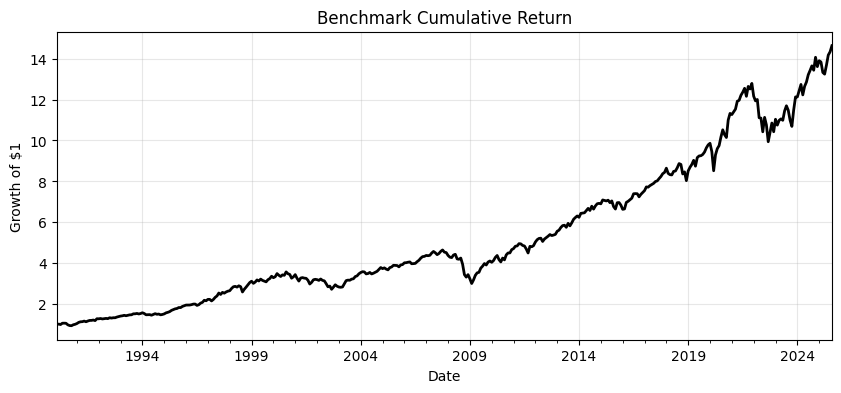

In [53]:
import matplotlib.pyplot as plt

bench_returns = (merged[ASSETS] * w_bench).sum(axis=1)
bench_returns.name = "Benchmark"
(1 + bench_returns).cumprod().plot(figsize=(10,4), lw=2, color='black', title="Benchmark Cumulative Return")
plt.ylabel("Growth of $1")
plt.grid(alpha=0.3)
plt.show()

In [54]:
R_train = merged.loc[:TRAIN_END, ASSETS].dropna(how="any")
labels  = reg_train_named.reindex(R_train.index)       # align index
labels_kmeans  = reg_kmeans_train_named.reindex(R_train.index)       # align index
labels_hmm  = reg_hmm_train_named.reindex(R_train.index)       # align index

def covs_by_label(R: pd.DataFrame, lbls: pd.Series, min_obs: int = 18):
    """Return dict[label]->(mu, Sigma, n) using Ledoit–Wolf shrinkage."""
    mu_dict, Sigma_dict, n_dict = {}, {}, {}
    for lab in sorted(lbls.dropna().unique()):
        mask = (lbls == lab)
        sub  = R.loc[mask]
        n    = len(sub)
        if n < min_obs:
            # fall back to global if too few obs
            sub = R
        mu = sub.mean()
        lw = LedoitWolf().fit(sub.values)
        Sigma = pd.DataFrame(lw.covariance_, index=R.columns, columns=R.columns)
        mu_dict[lab]    = mu
        Sigma_dict[lab] = Sigma
        n_dict[lab]     = n
    return mu_dict, Sigma_dict, n_dict

mu_lbl, Sigma_lbl, n_lbl = covs_by_label(R_train, labels)
mu_lbl_kmeans, Sigma_lbl_kmeans, n_lbl_kmeans = covs_by_label(R_train, labels_kmeans)
mu_lbl_hmm, Sigma_lbl_hmm, n_lbl_hmm = covs_by_label(R_train, labels_hmm)

In [55]:
bench_ret = (R_train * w_bench.reindex(ASSETS)).sum(axis=1)
bench_ret.name = "Benchmark"

rf = 0.0                             
excess = bench_ret - rf
lam_hat = float(excess.mean() / (excess.var(ddof=1) + 1e-12))
lam = lam_hat  # risk-aversion coefficient
print(f"Estimated lambda (monthly units): {lam:.3f}")

# mu_eq_lbl = {}
# for label, S in Sigma_lbl.items():
#     S = S.reindex(index=ASSETS, columns=ASSETS)          # enforce order
#     mu_eq_lbl[label] = pd.Series(lam * (S.values @ w_bench.reindex(ASSETS).values),
#                                  index=ASSETS, name=f"mu_eq[{label}]")

# mu_eq_df = pd.DataFrame({k: v for k, v in mu_eq_lbl.items()})
# print("\nEquilibrium priors (monthly):")
# display(mu_eq_df.round(6))

def compute_mu_eq_from_sigma(Sigma_dict, lam, ASSETS, w_bench):
    """
    Compute equilibrium prior means mu_eq for each regime label:
        μ_eq,k = λ Σ_k w_bench
    """
    mu_eq = {}
    for label, S in Sigma_dict.items():
        S = S.reindex(index=ASSETS, columns=ASSETS)

        mu_eq[label] = pd.Series(
            lam * (S.values @ w_bench.reindex(ASSETS).values),
            index=ASSETS,
            name=f"mu_eq[{label}]"
        )
    return mu_eq



Estimated lambda (monthly units): 9.380


In [56]:
# === BGMM — original model ===
mu_eq_lbl = compute_mu_eq_from_sigma(Sigma_lbl, lam, ASSETS, w_bench)
mu_eq_df  = pd.DataFrame({k: v for k, v in mu_eq_lbl.items()})
print("\nEquilibrium priors BGMM (monthly):")
display(mu_eq_df.round(6))
# === KMEANS REGIME MODEL ===
mu_eq_lbl_kmeans = compute_mu_eq_from_sigma(Sigma_lbl_kmeans, lam, ASSETS, w_bench)
mu_eq_df_kmeans  = pd.DataFrame({k: v for k, v in mu_eq_lbl_kmeans.items()})
print("\nEquilibrium priors for KMeans regimes:")
display(mu_eq_df_kmeans.round(6))
# === HMM REGIME MODEL ===
mu_eq_lbl_hmm = compute_mu_eq_from_sigma(Sigma_lbl_hmm, lam, ASSETS, w_bench)
mu_eq_df_hmm  = pd.DataFrame({k: v for k, v in mu_eq_lbl_hmm.items()})
print("\nEquilibrium priors for HMM regimes:")
display(mu_eq_df_hmm.round(6))


Equilibrium priors BGMM (monthly):


,Crisis,Mid Expansion,Steady State
Russell 1000 Value,0.004698,0.008315,0.010955
Russell 1000 Growth,0.005202,0.009509,0.013424
Russell 2000,0.004948,0.010241,0.013772
US Short-term Treasury,0.000461,-0.000130,0.000151
US Long-term Treasury,0.001520,-0.000626,0.000791
US IG Corporate Bond,0.001229,0.001700,0.001460
US HY Corporate Bond,0.001337,0.004309,0.003758



Equilibrium priors for KMeans regimes:


,Crisis,Mid Expansion,Steady State,Walking on Ice
Russell 1000 Value,0.033180,0.008214,0.002999,0.010578
Russell 1000 Growth,0.030410,0.010589,0.003301,0.012171
Russell 2000,0.037153,0.010718,0.003877,0.011380
US Short-term Treasury,-0.000038,-0.000355,0.000520,0.000533
US Long-term Treasury,0.004186,-0.001590,0.001578,0.001380
US IG Corporate Bond,0.011128,0.000707,0.001220,0.001786
US HY Corporate Bond,0.022104,0.003344,0.001174,0.002482



Equilibrium priors for HMM regimes:


,Correction,Crisis,Steady State
Russell 1000 Value,0.014441,0.009185,0.005307
Russell 1000 Growth,0.019916,0.010734,0.005839
Russell 2000,0.019514,0.011423,0.006418
US Short-term Treasury,-0.000426,0.000015,0.000265
US Long-term Treasury,-0.000506,0.000221,0.000235
US IG Corporate Bond,0.001522,0.001648,0.000993
US HY Corporate Bond,0.006715,0.004110,0.001676


In [57]:
import numpy as np
import pandas as pd

# ---------------- Utility: equilibrium (optional fallback) ---------------- #
def implied_equilibrium_returns(Sigma: pd.DataFrame,
                                w_bench: pd.Series,
                                lam_eq: float = 2.5) -> pd.Series:
    """mu_eq = lam * Sigma * w_bench (assets must be aligned)."""
    idx = w_bench.index
    S = Sigma.loc[idx, idx].values
    return pd.Series(lam_eq * (S @ w_bench.values), index=idx, name="mu_eq")

# ---------------- Utility: label normalization ---------------- #
def _norm_label(lbl: str) -> str:
    s = str(lbl).lower()
    if "walking" in s: return "walking on ice"
    if "mid"     in s: return "mid expansion"
    if "steady"  in s: return "steady"
    if "inflation" in s: return "inflation"
    if "crisis"    in s: return "crisis"
    if "recover"   in s: return "recovery"
    if "correct"   in s: return "correction"
    if "expansion" in s: return "expansion"
    return "neutral"

# ---------------- Black–Litterman posterior (single regime) ---------------- #
def bl_posterior(mu_eq: pd.Series,
                 Sigma: pd.DataFrame,
                 P: np.ndarray,
                 q: np.ndarray,
                 *,
                 tau: float = 0.05,
                 conf: float = 1.0) -> pd.Series:
    """
    mu_BL = [ (τΣ)^(-1) + P'Ω^(-1)P ]^(-1) [ (τΣ)^(-1) mu_eq + P'Ω^(-1) q ]
    with He–Litterman diagonal Ω scaled by confidence (larger 'conf' → smaller Ω).
    """
    # Align
    idx = mu_eq.index
    S = Sigma.loc[idx, idx].values
    mu0 = mu_eq.values

    # Shape checks
    n = len(idx)
    P = np.asarray(P, dtype=float)
    q = np.asarray(q, dtype=float).reshape(-1)
    assert P.shape[1] == n, f"P must be (m x {n}); got {P.shape}"
    assert P.shape[0] == q.shape[0], f"q length {q.shape[0]} must match P rows {P.shape[0]}"

    # He–Litterman Ω
    Sigma_tau = tau * S
    base_Omega = np.diag(np.diag(P @ Sigma_tau @ P.T))
    Omega = base_Omega / max(conf, 1e-6)

    A = np.linalg.inv(Sigma_tau) + P.T @ np.linalg.inv(Omega) @ P
    b = np.linalg.inv(Sigma_tau) @ mu0 + P.T @ np.linalg.inv(Omega) @ q
    mu_bl = np.linalg.solve(A, b)
    return pd.Series(mu_bl, index=idx, name="mu_bl")

# Assets (order must match your covariance/benchmark vectors)
ASSETS = [
    "Russell 1000 Value",
    "Russell 1000 Growth",
    "Russell 2000",
    "US Short-term Treasury",
    "US Long-term Treasury",
    "US IG Corporate Bond",
    "US HY Corporate Bond",
]

# 7-sleeve pick matrix (m x n) — tune/extend as needed
P_pick = np.array([
    [ 1,  -1,  0,  0,  0,  0,  0],        # Value - Growth
    [ 0,   0,  1, -1,  0,  0,  0],        # Small (R2K) - Bills (ST Tsy)
    [ 0,   0,  0, -1,  1,  0,  0],        # LT Tsy - ST Tsy
    [ 0,   0,  0,  0,  0, -1,  1],        # HY - IG
    [ 1/3, 1/3, 1/3, -1,  0,  0,  0],     # Equity basket - Bills
])

# Per-label monthly view vector q (length = rows of P_pick)
def q_for_label(lbl: str) -> np.ndarray:
    lbl = _norm_label(lbl)
    table = {
        "steady":         np.array([ +0.01/12, +0.01/12, -0.01/12,  0.00/12, +0.01/12 ]),
        "expansion":      np.array([ +0.02/12, +0.02/12, -0.01/12,  0.00/12, +0.03/12 ]),
        "mid expansion":  np.array([ +0.01/12, +0.01/12, -0.01/12,  0.00/12, +0.01/12 ]),
        "inflation":      np.array([ +0.01/12, -0.01/12, -0.03/12,  0.00/12, +0.01/12 ]),
        "crisis":         np.array([ -0.03/12, -0.03/12, +0.03/12, +0.04/12, -0.05/12 ]),
        "walking on ice": np.array([  0.00/12, +0.02/12, +0.02/12,  0.00/12, -0.01/12 ]),
        "correction":     np.array([ -0.01/12,  0.00/12,  0.00/12, +0.01/12, -0.02/12 ]),
        "recovery":       np.array([ +0.01/12, +0.02/12, -0.01/12,  0.00/12, +0.02/12 ]),
        "neutral":        np.zeros(P_pick.shape[0]),
    }
    return table.get(lbl, table["neutral"])

# Confidence per label (>1 = stronger views, <1 = weaker)
CONF = {
    "steady": 1.10, "expansion": 1.10, "mid expansion": 1.00,
    "inflation": 0.95, "crisis": 1.30, "walking on ice": 1.15,
    "correction": 0.95, "recovery": 1.15, "neutral": 1.00
}
def conf_for_label(lbl: str) -> float:
    return CONF.get(_norm_label(lbl), 1.0)

# ======================= Main: compute mu_BL per label ======================= #
def compute_mu_bl_by_label(Sigma_lbl: dict[str, pd.DataFrame],
                           mu_eq_lbl: dict[str, pd.Series] | None,
                           *,
                           w_bench: pd.Series | None = None,
                           lam_eq: float = 2.5,
                           tau: float = 0.05) -> dict[str, pd.Series]:
    """
    Inputs
    ------
    Sigma_lbl : dict[label] -> covariance (DataFrame, index/cols = ASSETS)
    mu_eq_lbl : dict[label] -> equilibrium mu (Series on ASSETS). If None, will compute
                using w_bench and lam_eq (requires w_bench).
    w_bench   : Series of benchmark weights on ASSETS (needed only if mu_eq_lbl is None)
    """
    # Align assets and optionally build mu_eq per label
    labels = list(Sigma_lbl.keys())
    mu_eq_lbl = {} if mu_eq_lbl is None else dict(mu_eq_lbl)

    for lab in labels:
        S = Sigma_lbl[lab].reindex(index=ASSETS, columns=ASSETS)
        Sigma_lbl[lab] = S
        if lab not in mu_eq_lbl:
            if w_bench is None:
                raise ValueError("mu_eq_lbl is None and w_bench not provided.")
            mu_eq_lbl[lab] = implied_equilibrium_returns(S, w_bench.reindex(ASSETS).fillna(0.0), lam_eq)

        # Ensure mu_eq aligned and 1–1 with ASSETS
        mu_eq_lbl[lab] = mu_eq_lbl[lab].reindex(ASSETS)

    assert P_pick.shape[1] == len(ASSETS), \
        f"P_pick second dimension must equal number of assets ({len(ASSETS)}); got {P_pick.shape}"

    mu_bl_lbl = {}
    for lab in labels:
        q = q_for_label(lab)
        c = conf_for_label(lab)
        mu_bl_lbl[lab] = bl_posterior(
            mu_eq=mu_eq_lbl[lab],
            Sigma=Sigma_lbl[lab],
            P=P_pick,
            q=q,
            tau=tau,
            conf=c,
        )
    return mu_bl_lbl

In [58]:
# mu_bl_lbl = compute_mu_bl_by_label(Sigma_lbl, mu_eq_lbl, w_bench=w_bench, lam_eq=2.5, tau=0.05)
# mu_bl_df = pd.DataFrame(mu_bl_lbl)  # columns = labels
# display(mu_bl_df.round(6))
# -----------------------------
# BGMM 
mu_bl_lbl = compute_mu_bl_by_label(
    Sigma_lbl,
    mu_eq_lbl,
    w_bench=w_bench,
    lam_eq=2.5,      # lam or 2.5 if you prefer
    tau=0.05,
)
mu_bl_df = pd.DataFrame(mu_bl_lbl)
print("BGMM BL posterior means:")
display(mu_bl_df.round(6))


# -----------------------------
# KMEANS RABL
mu_bl_lbl_kmeans = compute_mu_bl_by_label(
    Sigma_lbl_kmeans,
    mu_eq_lbl_kmeans,
    w_bench=w_bench,
    lam_eq=2.5,
    tau=0.05,
)
mu_bl_df_kmeans = pd.DataFrame(mu_bl_lbl_kmeans)
print("KMeans BL posterior means:")
display(mu_bl_df_kmeans.round(6))


# -----------------------------
# HMM RABL
mu_bl_lbl_hmm = compute_mu_bl_by_label(
    Sigma_lbl_hmm,
    mu_eq_lbl_hmm,
    w_bench=w_bench,
    lam_eq=2.5,
    tau=0.05,
)
mu_bl_df_hmm = pd.DataFrame(mu_bl_lbl_hmm)
print("HMM BL posterior means:")
display(mu_bl_df_hmm.round(6))

BGMM BL posterior means:


,Crisis,Mid Expansion,Steady State
Russell 1000 Value,0.000512,0.004560,0.005029
Russell 1000 Growth,0.001972,0.004381,0.005208
Russell 2000,-0.000636,0.003803,0.004975
US Short-term Treasury,0.000776,0.000353,0.000555
US Long-term Treasury,0.002146,0.000322,0.000572
US IG Corporate Bond,0.000298,0.001330,0.000897
US HY Corporate Bond,0.001579,0.001939,0.001325


KMeans BL posterior means:


,Crisis,Mid Expansion,Steady State,Walking on Ice
Russell 1000 Value,0.010976,0.004173,0.002067,0.005610
Russell 1000 Growth,0.011864,0.004342,0.001748,0.006074
Russell 2000,0.010400,0.003712,0.001999,0.004289
US Short-term Treasury,0.003058,0.000105,0.000462,0.001216
US Long-term Treasury,0.004726,-0.000139,0.000631,0.002170
US IG Corporate Bond,0.005705,0.000679,0.000681,0.001593
US HY Corporate Bond,0.008090,0.001307,0.000713,0.001445


HMM BL posterior means:


,Correction,Crisis,Steady State
Russell 1000 Value,0.006373,0.001960,0.003108
Russell 1000 Growth,0.007889,0.003487,0.002821
Russell 2000,0.005840,0.001673,0.002720
US Short-term Treasury,0.000421,0.000420,0.000350
US Long-term Treasury,0.000715,0.001907,0.000348
US IG Corporate Bond,0.001090,0.001281,0.000788
US HY Corporate Bond,0.002284,0.002549,0.000971


In [62]:
def build_P_lbl_from_named(
    reg_named: pd.Series,
    Sigma_lbl: dict,
    fallback_label: str = "Mid Expansion",
    smooth_window: int = 3,
) -> pd.DataFrame:
    """
    Build a smoothed probability table P_lbl (T × K) from
    a 1-step regime label series (reg_named).

    reg_named   : Series indexed by month-end dates with economic labels
    Sigma_lbl   : dict[label] -> covariance; keys define the valid labels (columns)
    fallback_label : label to use when reg_named has a category not in Sigma_lbl
    smooth_window  : rolling window size for smoothing probabilities (>=1)
    """
    # labels actually supported by this model
    labels_used = sorted(Sigma_lbl.keys())

    # empty one-hot matrix
    P_lbl = pd.DataFrame(0.0, index=reg_named.index, columns=labels_used)

    # map to valid labels, using fallback if needed
    lab_series = reg_named.reindex(P_lbl.index)
    lab_series = lab_series.where(lab_series.isin(labels_used), fallback_label)

    # fill one-hot
    ix = P_lbl.columns.get_indexer(lab_series.values)
    rows = np.arange(len(P_lbl))
    P_lbl.values[rows, ix] = 1.0

    # optional smoothing (e.g., 3-month rolling mean)
    if smooth_window is not None and smooth_window > 1:
        P_lbl = P_lbl.rolling(smooth_window, min_periods=1).mean()

    return P_lbl

In [65]:
P_lbl_bgmm = build_P_lbl_from_named(
    reg_named=reg_test_named,      # BGMM economic labels, TEST period
    Sigma_lbl=Sigma_lbl,           # BGMM label covariances
    fallback_label="Mid Expansion",
    smooth_window=3,
)

P_lbl_kmeans = build_P_lbl_from_named(
    reg_named=reg_kmeans_test_named,   # KMeans economic labels on TEST
    Sigma_lbl=Sigma_lbl_kmeans,        # KMeans label covariances
    fallback_label="Mid Expansion",
    smooth_window=3,
)

P_lbl_hmm = build_P_lbl_from_named(
    reg_named=reg_hmm_test_named,      # HMM economic labels on TEST
    Sigma_lbl=Sigma_lbl_hmm,           # HMM label covariances
    fallback_label="Mid Expansion",
    smooth_window=3,
)

In [67]:
# Build R_test from merged & TRAIN_END
R_test = merged.loc[TRAIN_END:, ASSETS].dropna(how="any").copy()


# Helper utilities (indexing & coercion)
def to_me_index(idx):
    """Coerce any index-like to tz-naive month-end timestamps."""
    dt = pd.to_datetime(idx)
    return dt.to_series().dt.to_period("M").dt.to_timestamp("M").index

def _ensure_sigma_df(v, assets):
    """
    Coerce any covariance object to an n×n DataFrame over `assets`.
    Supported:
      - DataFrame (will be reindexed)
      - ndarray (n×n)
      - Series with MultiIndex (unstack to DataFrame)
      - Series of length n (treated as diagonal variances)
    """
    if isinstance(v, pd.DataFrame):
        return v.reindex(index=assets, columns=assets)
    if isinstance(v, np.ndarray):
        if v.ndim == 2 and v.shape[0] == v.shape[1] == len(assets):
            return pd.DataFrame(v, index=assets, columns=assets)
        raise TypeError(f"ndarray Sigma has shape {v.shape}, expected ({len(assets)},{len(assets)})")
    if isinstance(v, pd.Series):
        if isinstance(v.index, pd.MultiIndex):
            df = v.unstack()
            return df.reindex(index=assets, columns=assets)
        if len(v) == len(assets):
            # treat as diagonal
            return pd.DataFrame(np.diag(v.values), index=assets, columns=assets)
        raise TypeError("Series Sigma unsupported (needs MultiIndex to unstack or length==n for diagonal).")
    raise TypeError(f"Unsupported Sigma type: {type(v)}")

# Blend label-level (mu, Sigma) into time-varying paths using Law of Total Covariance
def blend_label_params(P_lbl: pd.DataFrame,
                       mu_bl_lbl: dict,
                       Sigma_lbl: dict,
                       assets: list[str]) -> tuple[pd.DataFrame, dict]:
    """
    Returns:
      - mu_t: DataFrame (T×n) blended expected returns
      - Sigma_t_dict: dict[Timestamp] -> DataFrame (n×n) blended covariance using Law of Total Covariance
    
    The total covariance is decomposed as:
      Sigma_t = Sigma_within_t + Sigma_between_t
    where:
      - Sigma_within_t = sum_k p_{t,k} * Sigma_k (expected within-regime variance)
      - Sigma_between_t = sum_k p_{t,k} * (mu_k * mu_k') - mu_t * mu_t' (variance of conditional means)
    
    Only labels present in both mu_bl_lbl and Sigma_lbl and in P_lbl.columns are used.
    """
    labels = [c for c in P_lbl.columns if (c in mu_bl_lbl) and (c in Sigma_lbl)]
    if len(labels) == 0:
        raise ValueError("No overlapping labels between P_lbl and mu_bl_lbl/Sigma_lbl.")

    # stack for fast linear combos
    mu_stack = np.stack([mu_bl_lbl[l].reindex(assets).values for l in labels], axis=1)  # n × L
    Sig_stack = np.stack([Sigma_lbl[l].reindex(index=assets, columns=assets).values for l in labels], axis=2)  # n × n × L

    mu_t = pd.DataFrame(index=P_lbl.index, columns=assets, dtype=float)
    Sigma_t_dict = {}

    for t, p in P_lbl[labels].iterrows():
        w = p.values.reshape(-1, 1)                 # L × 1 (regime probabilities)
        mu_t_vec = (mu_stack @ w).ravel()          # n (blended mean)
        mu_t.loc[t] = mu_t_vec
        
        # Within-regime covariance: Sigma_within = sum_k p_k * Sigma_k
        Sigma_within = np.zeros((len(assets), len(assets)))
        for j in range(len(labels)):
            Sigma_within += float(w[j]) * Sig_stack[:, :, j]
        
        # Between-regime covariance: Sigma_between = sum_k p_k * (mu_k * mu_k') - mu_t * mu_t'
        Sigma_between = np.zeros((len(assets), len(assets)))
        for j in range(len(labels)):
            mu_k = mu_stack[:, j].reshape(-1, 1)   # n × 1
            Sigma_between += float(w[j]) * (mu_k @ mu_k.T)
        mu_t_outer = mu_t_vec.reshape(-1, 1) @ mu_t_vec.reshape(1, -1)
        Sigma_between -= mu_t_outer
        
        # Total covariance: Sigma_t = Sigma_within + Sigma_between
        Sigma_total = Sigma_within + Sigma_between
        Sigma_t_dict[t] = pd.DataFrame(Sigma_total, index=assets, columns=assets)

    return mu_t, Sigma_t_dict


In [68]:
mu_t_bgmm,   Sigma_t_bgmm   = blend_label_params(P_lbl_bgmm,   mu_bl_lbl,        Sigma_lbl,        ASSETS)
mu_t_kmeans, Sigma_t_kmeans = blend_label_params(P_lbl_kmeans, mu_bl_lbl_kmeans, Sigma_lbl_kmeans, ASSETS)
mu_t_hmm,    Sigma_t_hmm    = blend_label_params(P_lbl_hmm,    mu_bl_lbl_hmm,    Sigma_lbl_hmm,    ASSETS)

C:\Users\guoqi\AppData\Local\Temp\ipykernel_17308\1687988755.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sigma_within += float(w[j]) * Sig_stack[:, :, j]
C:\Users\guoqi\AppData\Local\Temp\ipykernel_17308\1687988755.py:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sigma_between += float(w[j]) * (mu_k @ mu_k.T)
C:\Users\guoqi\AppData\Local\Temp\ipykernel_17308\1687988755.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sigma_within += float(w[j]) * S

In [69]:
import numpy as np
import pandas as pd

# ---------- Benchmark-relative tilt optimizer ---------- #
def solve_bench_relative(mu: pd.Series,
                         Sigma: pd.DataFrame,
                         w_bench: pd.Series,
                         risk_aversion: float = 5.0,
                         delta: float = 0.10) -> pd.Series:
    """
    Simple benchmark-relative mean–variance tilt:

        max_w  (mu - mu_b)^T (w - w_b) - (λ/2) (w - w_b)^T Σ (w - w_b)

    subject to:
        sum_i w_i = 1,
        w_i >= 0,
        |w_i - w_{b,i}| <= δ   (per-asset deviation cap)

    Implemented as a closed-form proportional tilt toward positive
    relative expected returns, then clipped to ±delta and renormalized.
    """
    idx = w_bench.index

    # Coerce Sigma to a proper square DataFrame on idx
    if not isinstance(Sigma, pd.DataFrame):
        Sigma = pd.DataFrame(Sigma, index=idx, columns=idx)
    else:
        Sigma = Sigma.reindex(index=idx, columns=idx)

    mu = mu.reindex(idx)

    # Benchmark-implied expected returns (for “relative taste”)
    S = Sigma.values
    mu_b = risk_aversion * (S @ w_bench.values)
    mu_rel = pd.Series(mu.values - mu_b, index=idx)

    # Only tilt toward assets with positive relative expectation
    tilt = mu_rel.clip(lower=0.0)
    if tilt.sum() > 0:
        tilt = tilt / tilt.sum()
        # target weights = benchmark + capped deviation
        w_target = (w_bench + delta * (tilt - 1.0 / len(idx))).clip(
            lower=w_bench - delta,
            upper=w_bench + delta,
        )
        w = w_target.clip(lower=0.0)
        return w / w.sum()

    # If no positive signal, just hold the benchmark
    return w_bench.copy()


# ---------- Regime-aware Black–Litterman backtest ---------- #
def run_rabl_backtest_safe(R_test: pd.DataFrame,
                           mu_t: pd.DataFrame,
                           Sigma_t: dict,
                           w_bench: pd.Series,
                           delta: float = 0.10,
                           risk_aversion: float = 5.0,
                           tc_bps: float = 0.0):
    """
    Regime-aware BL backtest:

    Inputs
    ------
    R_test  : DataFrame (T × n) realized returns in TEST
    mu_t    : DataFrame (T × n) time-varying BL expected returns (from RABL)
    Sigma_t : dict[Timestamp] -> DataFrame (n × n) blended covariances
    w_bench : Series (n) benchmark weights on the same assets as R_test columns
    delta   : max abs deviation from benchmark per asset
    risk_aversion : λ in the benchmark-relative objective
    tc_bps  : round-trip transaction cost in basis points of traded notional

    Returns
    -------
    W   : DataFrame of portfolio weights over time
    NAV : Series of portfolio net asset value (starting at 1.0)
    summary : dict with AnnReturn, AnnVol, Sharpe(0%), MaxDD
    """
    assets = w_bench.index

    # Basic sanity checks
    assert list(R_test.columns) == list(assets), "Asset order mismatch between R_test and w_bench."
    assert set(mu_t.columns) >= set(assets), "mu_t missing some assets."
    assert all(isinstance(Sigma_t[t], pd.DataFrame) for t in Sigma_t), \
        "Sigma_t values must be DataFrames."

    # Containers
    W   = pd.DataFrame(index=R_test.index, columns=assets, dtype=float)
    NAV = pd.Series(index=R_test.index, dtype=float)

    w_prev = None

    for i, t in enumerate(R_test.index):
        # Covariance for this date (already aligned in Sigma_t)
        S_t = Sigma_t[t]

        # Solve benchmark-relative tilt using BL mu_t
        w = solve_bench_relative(mu_t.loc[t], S_t, w_bench, risk_aversion, delta)
        W.loc[t] = w

        # Realized return that month
        r = float((w * R_test.loc[t, assets]).sum())

        # Transaction costs (if any)
        tc = 0.0
        if (w_prev is not None) and (tc_bps > 0.0):
            tc = (tc_bps / 1e4) * float((w - w_prev).abs().sum())

        # NAV update
        NAV.iloc[i] = (1.0 if i == 0 else NAV.iloc[i - 1]) * (1.0 + r - tc)
        w_prev = w

    # Performance summary (monthly data assumed)
    port_ret = (W.shift(1).fillna(W.iloc[0]) * R_test[assets]).sum(axis=1)
    ann = 12
    er  = port_ret.mean() * ann
    vol = port_ret.std(ddof=1) * np.sqrt(ann)
    sharpe0 = er / (vol + 1e-12)
    mdd = (NAV / NAV.cummax()).min() - 1.0

    summary = {
        "AnnReturn": float(er),
        "AnnVol": float(vol),
        "Sharpe(0%)": float(sharpe0),
        "MaxDD": float(mdd),
    }
    return W, NAV, summary

In [70]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------------
# Assume these already exist:
#   merged, TRAIN_END, ASSETS, w_bench
#   mu_bl_lbl,   Sigma_lbl,   P_lbl          # BGMM
#   mu_bl_lbl_kmeans, Sigma_lbl_kmeans, P_lbl_kmeans
#   mu_bl_lbl_hmm,    Sigma_lbl_hmm,    P_lbl_hmm
# and helpers: to_me_index, _ensure_sigma_df, blend_label_params
# ------------------------------------------------------------------

# Build base R_test once (same for all models)
R_test_base = merged.loc[TRAIN_END:, ASSETS].dropna(how="any").copy()

def build_mu_Sigma_for_model(
    P_lbl_model: pd.DataFrame,
    mu_bl_lbl_model: dict,
    Sigma_lbl_model: dict,
    R_test_in: pd.DataFrame,
    assets: list[str],
    tag: str = ""
):
    """Blend regime-level (mu, Sigma) into time series and align to R_test."""
    # Basic checks for this model
    assert isinstance(R_test_in, pd.DataFrame) and len(assets) > 0
    assert isinstance(P_lbl_model, pd.DataFrame) and len(P_lbl_model) > 0
    assert isinstance(mu_bl_lbl_model, dict) and isinstance(Sigma_lbl_model, dict)

    # 1) Blend via Law of Total Covariance
    mu_t_raw, Sigma_t_raw = blend_label_params(
        P_lbl=P_lbl_model,
        mu_bl_lbl=mu_bl_lbl_model,
        Sigma_lbl=Sigma_lbl_model,
        assets=assets,
    )

    print(f"\n{'='*80}")
    print(f"{tag} – blended parameters (before alignment)")
    print("="*80)
    print(f"mu_t_raw shape: {mu_t_raw.shape}")
    print(f"Sigma_t_raw: {len(Sigma_t_raw)} time periods")

    # 2) Normalize indices to month-end
    R_test = R_test_in.copy()
    R_test.index  = to_me_index(R_test.index)
    mu_t_raw.index = to_me_index(mu_t_raw.index)
    P_lbl_model = P_lbl_model.copy()
    P_lbl_model.index = to_me_index(P_lbl_model.index)

    def _to_me(ts):
        return pd.Timestamp(ts).to_period("M").to_timestamp("M")

    # 3) Map Sigma_t_raw keys to month-end and build a raw dict
    Sigma_raw = {}
    for k, v in Sigma_t_raw.items():
        k_me = _to_me(k)
        Sigma_raw[k_me] = _ensure_sigma_df(v, R_test.columns)

    available_keys = sorted(Sigma_raw.keys())
    timeline = R_test.index.intersection(mu_t_raw.index).intersection(P_lbl_model.index)
    common_idx = timeline.sort_values()

    # 4) Forward-fill Sigma across time WITHOUT collapsing matrices
    Sigma_t_ff = {}
    last_S = None
    it = iter(available_keys)
    next_key = next(it, None)

    for t in common_idx:
        if t in Sigma_raw:
            last_S = Sigma_raw[t]
        else:
            while next_key is not None and next_key <= t:
                last_S = Sigma_raw[next_key]
                next_key = next(it, None)
            if last_S is None and available_keys:
                last_S = Sigma_raw[available_keys[0]]
        Sigma_t_ff[t] = last_S

    if len(Sigma_t_ff) == 0:
        raise ValueError(f"[{tag}] No covariance matrices matched the test timeline.")

    # 5) Truncate mu_t to the common_idx so it lines up with Sigma_t_ff and R_test
    mu_t = mu_t_raw.loc[common_idx]
    R_test_aligned = R_test.loc[common_idx]

    print(f"\n✓ [{tag}] Forward-filled Sigma to {len(Sigma_t_ff)} time points.")
    print(f"✓ [{tag}] mu_t aligned shape: {mu_t.shape}")
    return R_test_aligned, mu_t, Sigma_t_ff



In [72]:
# =========================
# 1) BGMM RABL parameters
# =========================
R_test_bgmm, mu_t_bgmm, Sigma_t_bgmm = build_mu_Sigma_for_model(
    P_lbl_model=P_lbl_bgmm,
    mu_bl_lbl_model=mu_bl_lbl,
    Sigma_lbl_model=Sigma_lbl,
    R_test_in=R_test_base,
    assets=ASSETS,
    tag="BGMM",
)

# =========================
# 2) KMEANS RABL parameters
# =========================
R_test_kmeans, mu_t_kmeans, Sigma_t_kmeans = build_mu_Sigma_for_model(
    P_lbl_model=P_lbl_kmeans,
    mu_bl_lbl_model=mu_bl_lbl_kmeans,
    Sigma_lbl_model=Sigma_lbl_kmeans,
    R_test_in=R_test_base,
    assets=ASSETS,
    tag="KMeans",
)

# =========================
# 3) HMM RABL parameters
# =========================
R_test_hmm, mu_t_hmm, Sigma_t_hmm = build_mu_Sigma_for_model(
    P_lbl_model=P_lbl_hmm,
    mu_bl_lbl_model=mu_bl_lbl_hmm,
    Sigma_lbl_model=Sigma_lbl_hmm,
    R_test_in=R_test_base,
    assets=ASSETS,
    tag="HMM",
)


BGMM – blended parameters (before alignment)
mu_t_raw shape: (65, 7)
Sigma_t_raw: 65 time periods

✓ [BGMM] Forward-filled Sigma to 65 time points.
✓ [BGMM] mu_t aligned shape: (65, 7)

KMeans – blended parameters (before alignment)
mu_t_raw shape: (65, 7)
Sigma_t_raw: 65 time periods

✓ [KMeans] Forward-filled Sigma to 65 time points.
✓ [KMeans] mu_t aligned shape: (65, 7)

HMM – blended parameters (before alignment)
mu_t_raw shape: (65, 7)
Sigma_t_raw: 65 time periods

✓ [HMM] Forward-filled Sigma to 65 time points.
✓ [HMM] mu_t aligned shape: (65, 7)


C:\Users\guoqi\AppData\Local\Temp\ipykernel_17308\1687988755.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sigma_within += float(w[j]) * Sig_stack[:, :, j]
C:\Users\guoqi\AppData\Local\Temp\ipykernel_17308\1687988755.py:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sigma_between += float(w[j]) * (mu_k @ mu_k.T)
C:\Users\guoqi\AppData\Local\Temp\ipykernel_17308\1687988755.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sigma_within += float(w[j]) * S

In [73]:
W_bgmm,   nav_bgmm,   summary_bgmm   = run_rabl_backtest_safe(R_test_bgmm,   mu_t_bgmm,   Sigma_t_bgmm,   w_bench)
W_kmeans, nav_kmeans, summary_kmeans = run_rabl_backtest_safe(R_test_kmeans, mu_t_kmeans, Sigma_t_kmeans, w_bench)
W_hmm,    nav_hmm,    summary_hmm    = run_rabl_backtest_safe(R_test_hmm,    mu_t_hmm,    Sigma_t_hmm,    w_bench)


#### Visualization & Comparison

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ----------------------------
# Helper: Max Drawdown
# ----------------------------
def calculate_max_drawdown(series: pd.Series) -> float:
    cumulative_max = series.cummax()
    drawdown = (series / cumulative_max) - 1
    return drawdown.min()

# ----------------------------
# Helper: full analysis for one strategy
# ----------------------------
def analyze_strategy(
    nav_series: pd.Series,
    W: pd.DataFrame,
    reg_named: pd.Series,
    R_test: pd.DataFrame,
    w_bench: pd.Series,
    label: str,
    regime_colors: dict[str, str],
):
    """
    Do everything you did for BGMM:
      - plot NAV vs benchmark
      - overlay regimes
      - compute Sharpe, IR, cumulative return, max DD
      - plot stacked weights
      - print metrics / comparison table
    """
    nav_series = nav_series.dropna()
    # 1) Benchmark cumulative returns
    bench_returns = (R_test * w_bench).sum(axis=1).loc[nav_series.index]
    bench_cum_returns = (1 + bench_returns).cumprod()

    # ------------- Plot NAV vs Benchmark -------------
    plt.figure(figsize=(12, 6))
    plt.plot(nav_series, label=f"{label}", lw=2)
    plt.plot(bench_cum_returns, label="Benchmark", color="black", lw=2, linestyle="--")
    plt.title(f"{label} vs Benchmark", fontsize=14, fontweight="bold")
    plt.ylabel("Cumulative Return")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # ------------- NAV vs Benchmark with Regime overlay -------------
    # Build legend patches
    legend_patches = [Patch(color=color, label=lab) for lab, color in regime_colors.items()]

    plt.figure(figsize=(12, 6))
    plt.plot(nav_series, label=f"{label}", lw=2)
    plt.plot(bench_cum_returns, label="Benchmark", color="black", lw=2, linestyle="--")

    # Restrict regimes to the same index as nav_series
    reg_aligned = reg_named.reindex(nav_series.index).ffill()

    for start_date, end_date in zip(reg_aligned.index[:-1], reg_aligned.index[1:]):
        regime = reg_aligned.loc[start_date]
        plt.axvspan(start_date, end_date,
                    color=regime_colors.get(regime, "gray"), alpha=0.2)

    plt.title(f"{label} vs Benchmark with Regime Overlay", fontsize=14, fontweight="bold")
    plt.ylabel("Cumulative Return")
    plt.xlabel("Date")
    plt.legend(
        handles=legend_patches + [
            Patch(color="blue", label=label),
            Patch(color="black", label="Benchmark"),
        ],
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
    )
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ------------- Performance metrics -------------
    # Monthly returns
    port_monthly_returns = nav_series.pct_change().dropna()
    bench_monthly_returns = bench_cum_returns.pct_change().dropna()

    # Align
    common_idx = port_monthly_returns.index.intersection(bench_monthly_returns.index)
    port_monthly_returns = port_monthly_returns.loc[common_idx]
    bench_monthly_returns = bench_monthly_returns.loc[common_idx]

    # Portfolio metrics
    port_ann_return = port_monthly_returns.mean() * 12
    port_ann_vol = port_monthly_returns.std(ddof=1) * np.sqrt(12)
    port_sharpe = port_ann_return / (port_ann_vol + 1e-12)

    # Benchmark metrics
    bench_ann_return = bench_monthly_returns.mean() * 12
    bench_ann_vol = bench_monthly_returns.std(ddof=1) * np.sqrt(12)
    bench_sharpe = bench_ann_return / (bench_ann_vol + 1e-12)

    # Information ratio
    excess_returns = port_monthly_returns - bench_monthly_returns
    tracking_error = excess_returns.std(ddof=1) * np.sqrt(12)
    information_ratio = (excess_returns.mean() * 12) / (tracking_error + 1e-12)

    # Cumulative returns
    cum_returns_portfolio = nav_series.iloc[-1] - 1.0
    cum_returns_benchmark = bench_cum_returns.iloc[-1] - 1.0

    # Max drawdowns
    max_dd_port = calculate_max_drawdown(nav_series)
    max_dd_bench = calculate_max_drawdown(bench_cum_returns)

    # ------------- Print & comparison table -------------
    comparison_table = pd.DataFrame(
        {
            "Metric": [
                "Annualized Return",
                "Annualized Volatility",
                "Sharpe Ratio",
                "Max Drawdown",
                "Information Ratio",
                "Cumulative Return",
            ],
            label: [
                port_ann_return,
                port_ann_vol,
                port_sharpe,
                max_dd_port,
                information_ratio,
                cum_returns_portfolio,
            ],
            "Benchmark": [
                bench_ann_return,
                bench_ann_vol,
                bench_sharpe,
                max_dd_bench,
                np.nan,
                cum_returns_benchmark,
            ],
        }
    )
    print(f"\n=== Performance summary: {label} ===")
    display(comparison_table)

    # ------------- Stacked weights over time -------------
    W_plot = W.reindex(nav_series.index).dropna(how="all")

    plt.figure(figsize=(14, 6))
    W_plot.plot(
        kind="bar",
        stacked=True,
        width=1.0,
        alpha=0.85,
        colormap="tab10",
    )
    plt.title(f"Portfolio Weight Changes Over Time — {label}", fontsize=14, fontweight="bold")
    plt.ylabel("Weight")
    plt.xlabel("Date")

    tick_positions = range(0, len(W_plot.index), max(1, len(W_plot.index)//15))
    tick_labels = W_plot.index[list(tick_positions)].strftime('%Y-%m')
    plt.xticks(tick_positions, tick_labels, rotation=45)
    plt.legend(title="Assets", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # return metrics if you want to store
    return {
        "AnnReturn": float(port_ann_return),
        "AnnVol": float(port_ann_vol),
        "Sharpe": float(port_sharpe),
        "BenchAnnReturn": float(bench_ann_return),
        "BenchAnnVol": float(bench_ann_vol),
        "BenchSharpe": float(bench_sharpe),
        "IR": float(information_ratio),
        "CumRet_Port": float(cum_returns_portfolio),
        "CumRet_Bench": float(cum_returns_benchmark),
        "MaxDD_Port": float(max_dd_port),
        "MaxDD_Bench": float(max_dd_bench),
    }



In [77]:
regime_colors = {
    "Mid Expansion": "cornflowerblue",
    "Steady State": "lightgreen",
    "Walking on Ice": "orange",
    "Inflation": "red",
    "Crisis": "purple",
    "Correction": "gold",
}

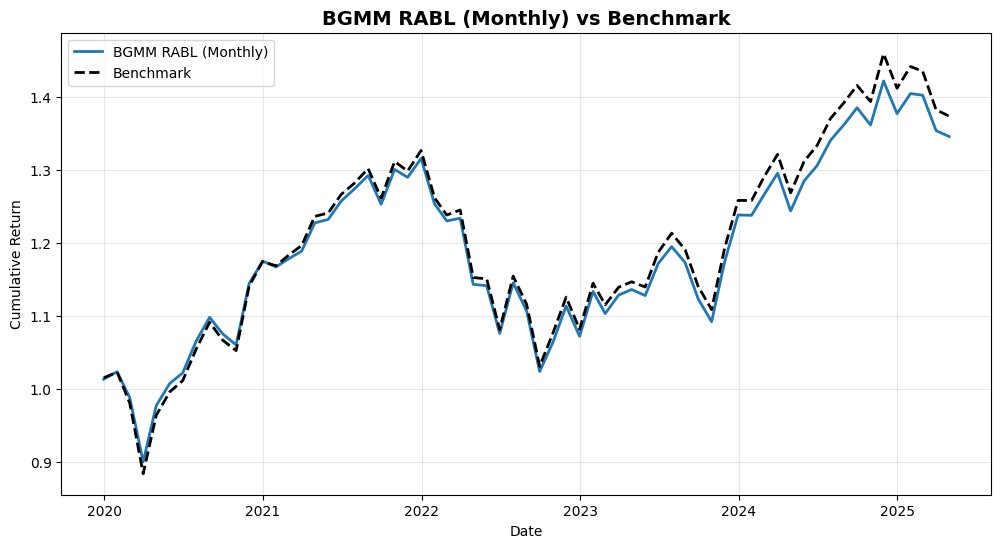

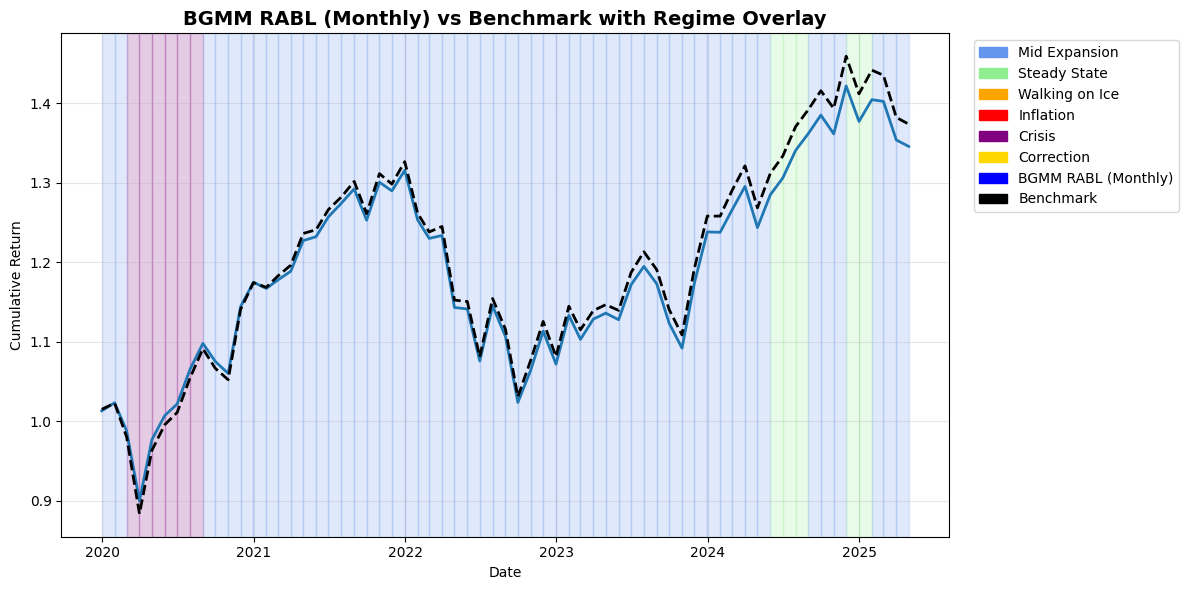


=== Performance summary: BGMM RABL (Monthly) ===


,Metric,BGMM RABL (Monthly),Benchmark
0,Annualized Return,0.061460,0.065729
1,Annualized Volatility,0.128531,0.134226
2,Sharpe Ratio,0.478172,0.489692
3,Max Drawdown,-0.221783,-0.222792
4,Information Ratio,-0.510797,NaN
5,Cumulative Return,0.345576,0.373584


<Figure size 1400x600 with 0 Axes>

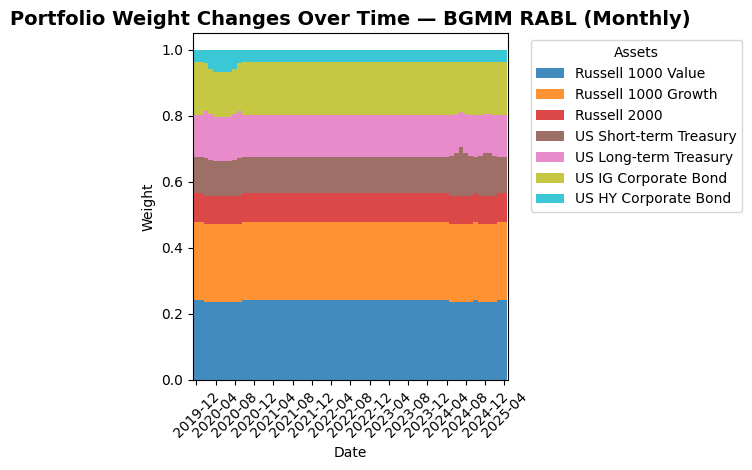


BGMM metrics: {'AnnReturn': 0.06145971727568469, 'AnnVol': 0.12853062472164206, 'Sharpe': 0.478171777413433, 'BenchAnnReturn': 0.06572936975951899, 'BenchAnnVol': 0.13422592040017783, 'BenchSharpe': 0.48969207708217144, 'IR': -0.5107972191728379, 'CumRet_Port': 0.34557567864514493, 'CumRet_Bench': 0.3735838958563156, 'MaxDD_Port': -0.22178279718109728, 'MaxDD_Bench': -0.22279226862233215}


In [78]:
# 1) BGMM RABL (use whatever you consider "final": nav or nav_monthly)

metrics_bgmm = analyze_strategy(
    nav_series=nav_bgmm,          # or `nav` if that's your BGMM RABL NAV
    W=W_bgmm,                     # or `W` if using the original RABL weights
    reg_named=reg_test_named,        # BGMM economic labels in TEST
    R_test=R_test,
    w_bench=w_bench,
    label="BGMM RABL (Monthly)",
    regime_colors=regime_colors,
)


print("\nBGMM metrics:",  metrics_bgmm)



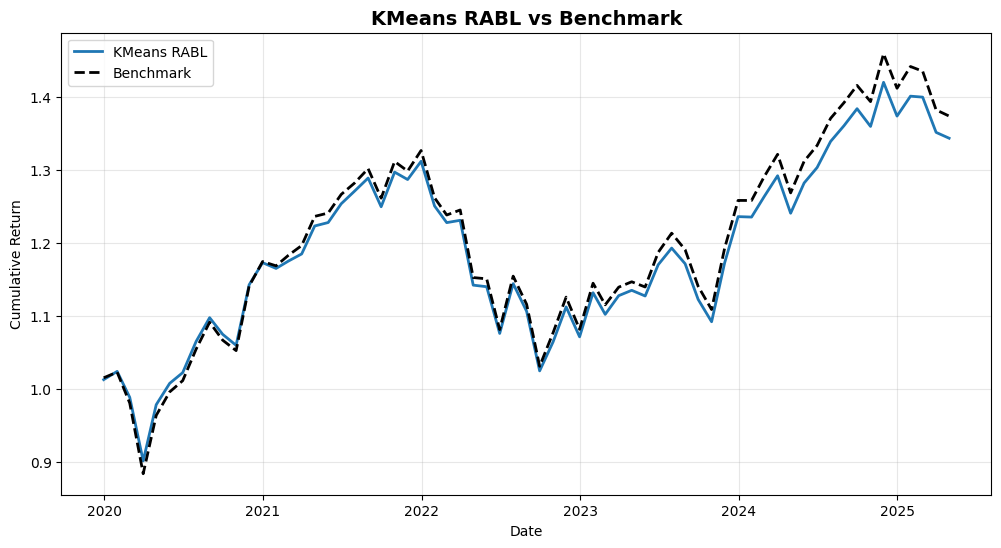

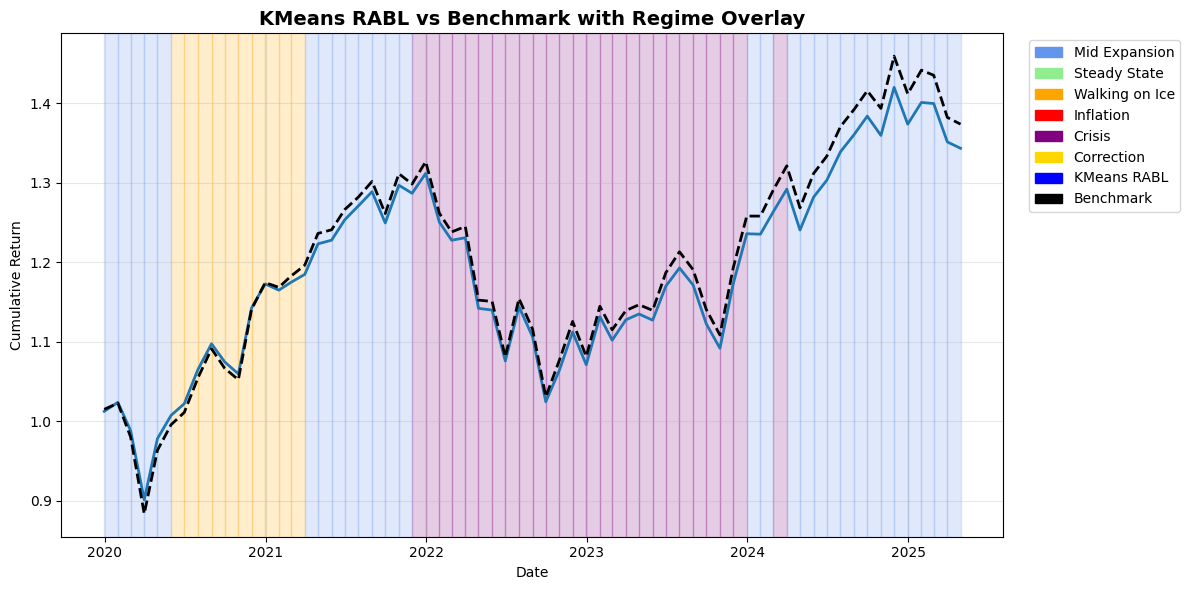


=== Performance summary: KMeans RABL ===


,Metric,KMeans RABL,Benchmark
0,Annualized Return,0.061077,0.065729
1,Annualized Volatility,0.127195,0.134226
2,Sharpe Ratio,0.480182,0.489692
3,Max Drawdown,-0.218841,-0.222792
4,Information Ratio,-0.485328,NaN
5,Cumulative Return,0.343252,0.373584


<Figure size 1400x600 with 0 Axes>

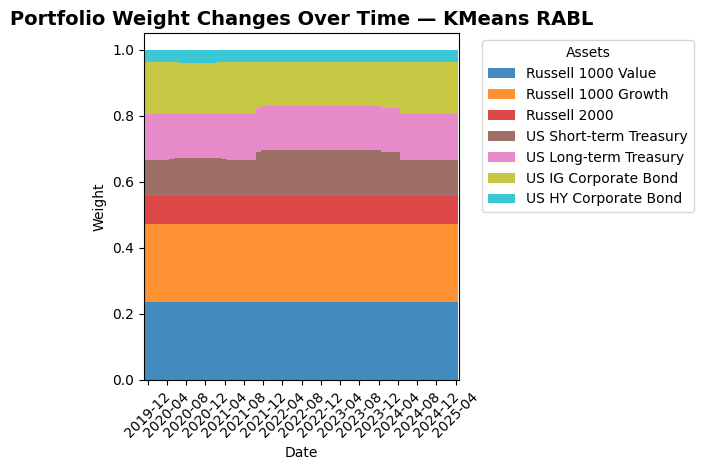

KMeans metrics: {'AnnReturn': 0.061076779410706904, 'AnnVol': 0.1271951668461712, 'Sharpe': 0.48018160535999366, 'BenchAnnReturn': 0.06572936975951899, 'BenchAnnVol': 0.13422592040017783, 'BenchSharpe': 0.48969207708217144, 'IR': -0.4853275034348174, 'CumRet_Port': 0.3432523293534171, 'CumRet_Bench': 0.3735838958563156, 'MaxDD_Port': -0.21884066652696987, 'MaxDD_Bench': -0.22279226862233215}


In [79]:
# 2) KMeans RABL
metrics_kmeans = analyze_strategy(
    nav_series=nav_kmeans,           # from your KMeans RABL backtest
    W=W_kmeans,
    reg_named=reg_kmeans_test_named, # economic labels from KMeans, TEST period
    R_test=R_test,
    w_bench=w_bench,
    label="KMeans RABL",
    regime_colors=regime_colors,
)

print("KMeans metrics:", metrics_kmeans)

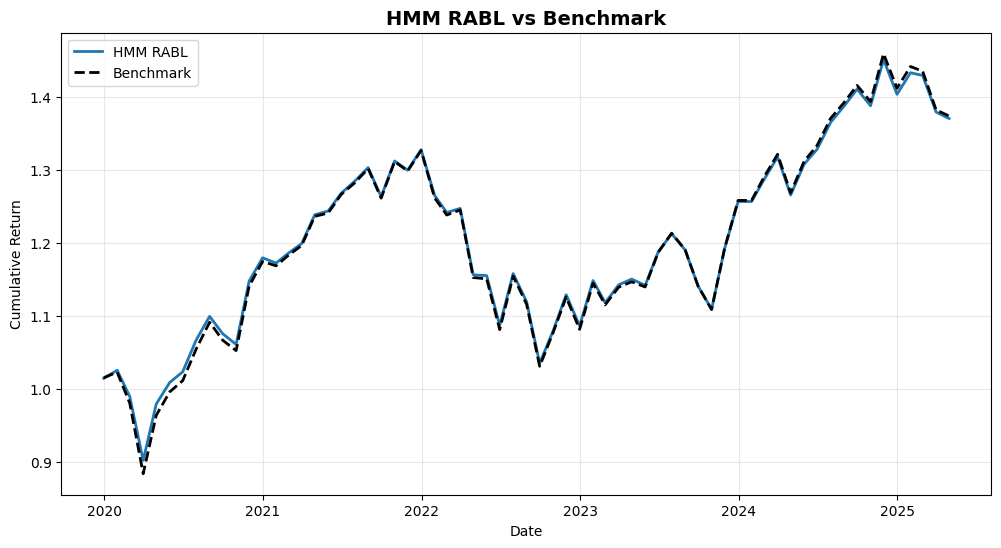

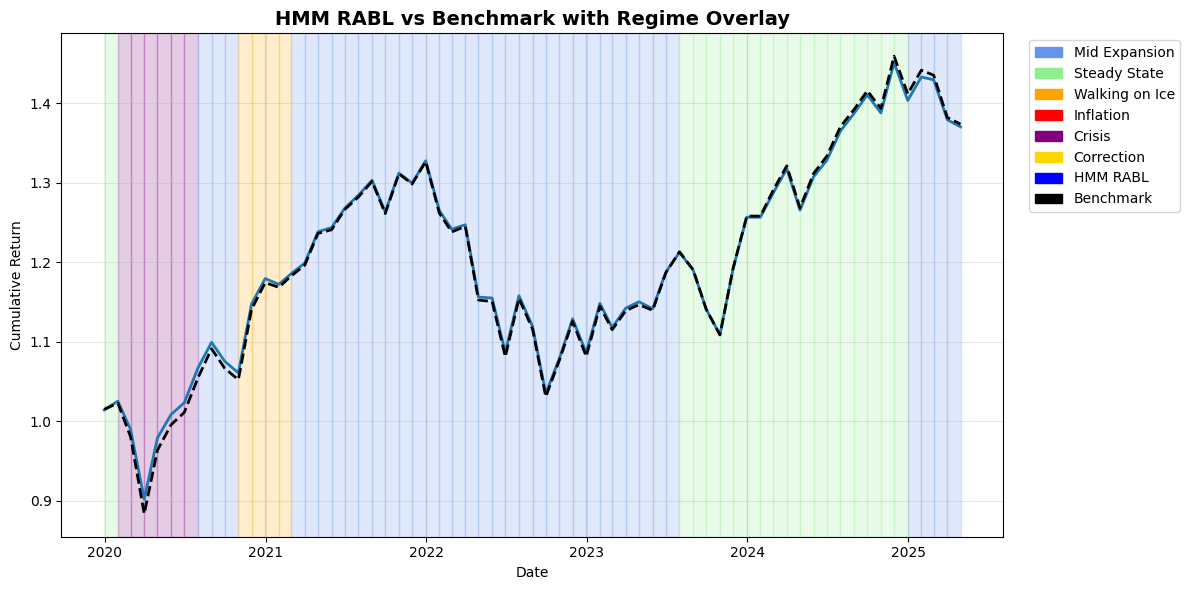


=== Performance summary: HMM RABL ===


,Metric,HMM RABL,Benchmark
0,Annualized Return,0.064793,0.065729
1,Annualized Volatility,0.129521,0.134226
2,Sharpe Ratio,0.500249,0.489692
3,Max Drawdown,-0.220344,-0.222792
4,Information Ratio,-0.131093,NaN
5,Cumulative Return,0.370235,0.373584


<Figure size 1400x600 with 0 Axes>

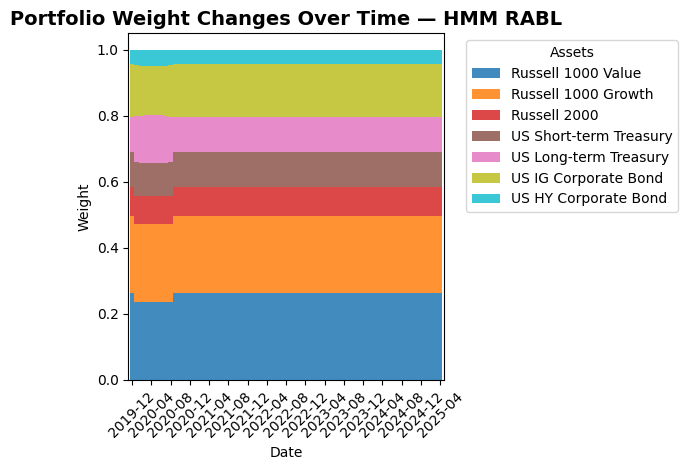

HMM metrics: {'AnnReturn': 0.06479274496406118, 'AnnVol': 0.1295209201288837, 'Sharpe': 0.5002492639728544, 'BenchAnnReturn': 0.06572936975951899, 'BenchAnnVol': 0.13422592040017783, 'BenchSharpe': 0.48969207708217144, 'IR': -0.1310931886714325, 'CumRet_Port': 0.3702350866480466, 'CumRet_Bench': 0.3735838958563156, 'MaxDD_Port': -0.2203439437395598, 'MaxDD_Bench': -0.22279226862233215}


In [80]:
# 3) HMM RABL
metrics_hmm = analyze_strategy(
    nav_series=nav_hmm,              # from your HMM RABL backtest
    W=W_hmm,
    reg_named=reg_hmm_test_named,    # economic labels from HMM, TEST period
    R_test=R_test,
    w_bench=w_bench,
    label="HMM RABL",
    regime_colors=regime_colors,
)

print("HMM metrics:", metrics_hmm)